In [1]:
#Import tensorflow

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Test if GPU is found

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [3]:
#Autosaving every 10s

%autosave 10

Autosaving every 10 seconds


In [4]:
#Training & Testing files

train_file = "train13.csv"
val_file = "val13.csv"
matlab_file = '1_50_13.mat'
rul_file = "rul_50_13.csv"
fleet_Rul_File = "rul13.csv"
test_file = "test13.csv"

In [5]:
import pandas as pd
import numpy as np
import scipy.io
import tensorflow_probability as tfp
import matplotlib as plt
import matplotlib.pyplot as plt
import pickle
import scipy.io as spio
import pickle
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Masking
tfd = tfp.distributions

In [6]:
# fix random seed for reproducibility

np.random.seed(0)

In [7]:
#load Training & Testing files into Pandas Dataframes

train = pd.read_csv(train_file, index_col=False)
val = pd.read_csv(val_file, index_col=False)
mat = spio.loadmat(matlab_file, squeeze_me=True)

C:\Users\Asus\anaconda3\lib\site-packages\scipy\io\matlab\mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [8]:
#Load Hyperparameters Obtained by BayesOpt

lr = mat['lr']
ep = mat['ep']
batch = mat['batch']
pad = mat['Pad']
L2 = mat['L2'] 
unit1 = mat['unit'] 
size1 = mat['size']
drop1 = mat['drop']

lr,ep,batch,pad,L2,unit1,size1,drop1

(0.000620063209401073, 1e-08, 66, 303, 0.0001, 14, 178, 0.45660544050854435)

In [9]:
#Xtrain to Numpy multidimensional array

xtrain_cut = train.drop(['Fleet','Cycle','RUL'], axis=1)
xtrain = np.zeros((train['Fleet'].max(),pad,xtrain_cut.shape[1]))
for i in range(train['Fleet'].max()):
    df_xtrain = train.loc[train['Fleet']==i+1]
    df_xtrain = df_xtrain.drop(['Fleet','Cycle','RUL'], axis=1)
    np_xtrain = df_xtrain.values
    result = np.zeros((pad,df_xtrain.shape[1]))
    result[:np_xtrain.shape[0],:np_xtrain.shape[1]] = np_xtrain
    xtrain[i] = result
xtrain.shape

(100, 303, 13)

In [10]:
#Ytrain to Numpy multidimensional array

ytrain_cut = train[['RUL']]
ytrain = np.zeros((train['Fleet'].max(),pad,1))
for i in range(train['Fleet'].max()):
    df_ytrain = train.loc[train['Fleet']==i+1]
    df_ytrain = df_ytrain[['RUL']]
    np_ytrain = df_ytrain.values
    result = np.zeros((pad,df_ytrain.shape[1]))
    result[:np_ytrain.shape[0],:np_ytrain.shape[1]] = np_ytrain
    ytrain[i] = result
ytrain.shape

(100, 303, 1)

In [11]:
#Ytrain2 to Numpy multidimensional array - for SHAP

ytrain2 = np.zeros(train['Fleet'].max())
for i in range(train['Fleet'].max()):
    df_ytrain2 = train.loc[train['Fleet']==i+1]
    df_ytrain2 = df_ytrain2[['RUL']].values
    ytrain2[i] = df_ytrain2[0]
ytrain2.shape

(100,)

In [12]:
#Xval to Numpy multidimensional array

xval_cut = val.drop(['RUL','Fleet','Cycle'], axis=1)
xval = np.zeros((val['Fleet'].max(),pad,xval_cut.shape[1]))
for i in range(val['Fleet'].max()):
    df_xval = val.loc[val['Fleet']==i+1]
    df_xval = df_xval.drop(['Fleet','Cycle','RUL'], axis=1)
    np_xval = df_xval.values
    result = np.zeros((pad,df_xval.shape[1]))
    result[:np_xval.shape[0],:np_xval.shape[1]] = np_xval
    xval[i] = result
xval.shape

(100, 303, 13)

In [13]:
#Yval to Numpy multidimensional array - for sequential prediction 

yval_cut = val[['RUL']]
yval = np.zeros((val['Fleet'].max(),pad,1))
for i in range(val['Fleet'].max()):
    df_yval = val.loc[val['Fleet']==i+1]
    df_yval = df_yval[['RUL']]
    np_yval = df_yval.values
    result = np.zeros((pad,df_yval.shape[1]))
    result[:np_yval.shape[0],:np_yval.shape[1]] = np_yval
    yval[i] = result
yval.shape

(100, 303, 1)

In [14]:
#Yval2 to Numpy multidimensional array - for SHAP 

yval2 = np.zeros(train['Fleet'].max())
for i in range(train['Fleet'].max()):
    df_yval2 = train.loc[train['Fleet']==i+1]
    df_yval2 = df_yval2[['RUL']].values
    yval2[i] = df_yval2[0]
yval2.shape

(100,)

In [15]:
#xtest to Numpy multidimensional array 

test = pd.read_csv(test_file, index_col=False)
xtest_cut = test.drop(['Fleet','Cycle'], axis=1)
xtest = np.zeros((test['Fleet'].max(),pad,xtest_cut.shape[1]))
for i in range(test['Fleet'].max()):
    df_xtest = test.loc[test['Fleet']==i+1]
    df_xtest = df_xtest.drop(['Fleet','Cycle'], axis=1)
    np_xtest = df_xtest.values
    result = np.zeros((pad,df_xtest.shape[1]))
    result[:np_xtest.shape[0],:np_xtest.shape[1]] = np_xtest
    xtest[i] = result

In [16]:
#Verify shapes of array

xtrain.shape,ytrain.shape, ytrain2.shape,xval.shape,yval.shape,yval2.shape,xtest.shape

((100, 303, 13),
 (100, 303, 1),
 (100,),
 (100, 303, 13),
 (100, 303, 1),
 (100,),
 (100, 303, 13))

In [17]:
xtrain = xtrain.astype(np.float32)
ytrain = ytrain.astype(np.float32)
ytrain2 = ytrain2.astype(np.float32)
xval = xval.astype(np.float32)
yval = yval.astype(np.float32)
yval2 = yval2.astype(np.float32)
xtest = xtest.astype(np.float32)

In [18]:
#Set ytrain for 3 outputs

x_train = xtrain
y_train = [ytrain,ytrain,ytrain2]
x_val = xval
y_val = [yval,yval,yval2]
x_test = xtest

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback,ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Reshape
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.models import Model
from IPython.display import display

In [20]:
# Define trainable prior

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [21]:
#Define probabilistic LSTM

#LSTM layers (layer 1,2&3)

inputs = tf.keras.Input(shape=(303,13),dtype='float32')
layer1 = LSTM(unit1,return_sequences = True)(inputs)
layer2 = Dense(size1)(layer1)

#Output 1 = Aleatoric output layer (layer 3&4)

layer3 = Dense(1+1)(layer2)
layer4 = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])),name='out1')(layer3) #aleatoric

#Output 2 = Epistemic output layer (layer 5&6)

layer5 = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable)(layer2)
layer6 = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1),name = 'out2')(layer5)

#Output 3 = Slicer output layer (layer 7&8)

layer7 = Dense(1)(layer2)
layer8 = Lambda(lambda t: t[:,-1],name='out3')(layer7)

model = tf.keras.Model(inputs=inputs, outputs=[layer4,layer6,layer8])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 303, 13)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 303, 14)      1568        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 303, 178)     2670        lstm[0][0]                       
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 303, 2)       358         dense[0][0]                      
_______________________________________________________________________________________

In [22]:
#Define directory for best weights checkpoint

import os
checkpoint_path = "C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/Gas Turbine & Turbofan AD & PROGNOS/Turbofan/Turbofan-1 LSTM 13/model checkpoint/1_50_13_ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Callback for best weights checkpoint

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)

In [23]:
#Compile model

optimizers.Adam(learning_rate=lr, beta_1 = 0.9,beta_2 = 0.999, epsilon = ep, amsgrad = False, name = "Adam")
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(loss = {'out1': negloglik,'out2': negloglik,'out3':'mean_squared_error'},loss_weights=[0.5,0.5,0],optimizer= 'Adam')

In [24]:
#Set Tensorboard  

%load_ext tensorboard
import tensorboard
tensorboard.__version__
from datetime import datetime
from tensorflow import keras
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
# Run training on GPU

history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10000, batch_size  = batch, verbose = 0, callbacks=[model_checkpoint_callback,tensorboard_callback])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_loss improved from inf to 221.47293, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_13_ckpt

Epoch 00002: val_loss improved from 221.47293 to 218.37002, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_13_ckpt

Epoch 00003: val_loss improved from 218.37002 to 213.12007, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_13_ckpt

Epoch 00004: val_loss did not improve from 213.12007

Epoch 00005: val_loss did not improve from 213.12007

Epoch 00006: val_loss did not improve from 213.12007

Epoch 00007: val_loss improved from 213.12007 to 210.27814, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_13_ckpt

Epoch 00008: val_loss 


Epoch 00065: val_loss improved from 60.92669 to 46.75710, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_13_ckpt

Epoch 00066: val_loss did not improve from 46.75710

Epoch 00067: val_loss did not improve from 46.75710

Epoch 00068: val_loss did not improve from 46.75710

Epoch 00069: val_loss did not improve from 46.75710

Epoch 00070: val_loss did not improve from 46.75710

Epoch 00071: val_loss did not improve from 46.75710

Epoch 00072: val_loss did not improve from 46.75710

Epoch 00073: val_loss did not improve from 46.75710

Epoch 00074: val_loss did not improve from 46.75710

Epoch 00075: val_loss did not improve from 46.75710

Epoch 00076: val_loss did not improve from 46.75710

Epoch 00077: val_loss improved from 46.75710 to 38.97912, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_13_ckpt

Epoch 00078: val_loss did not improve from 38.97912

Epoch 00079: va


Epoch 00186: val_loss did not improve from 14.68748

Epoch 00187: val_loss did not improve from 14.68748

Epoch 00188: val_loss did not improve from 14.68748

Epoch 00189: val_loss improved from 14.68748 to 13.78604, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_13_ckpt

Epoch 00190: val_loss did not improve from 13.78604

Epoch 00191: val_loss did not improve from 13.78604

Epoch 00192: val_loss did not improve from 13.78604

Epoch 00193: val_loss did not improve from 13.78604

Epoch 00194: val_loss did not improve from 13.78604

Epoch 00195: val_loss did not improve from 13.78604

Epoch 00196: val_loss did not improve from 13.78604

Epoch 00197: val_loss did not improve from 13.78604

Epoch 00198: val_loss did not improve from 13.78604

Epoch 00199: val_loss did not improve from 13.78604

Epoch 00200: val_loss did not improve from 13.78604

Epoch 00201: val_loss did not improve from 13.78604

Epoch 00202: val_loss did not 


Epoch 00327: val_loss did not improve from 11.38759

Epoch 00328: val_loss did not improve from 11.38759

Epoch 00329: val_loss did not improve from 11.38759

Epoch 00330: val_loss did not improve from 11.38759

Epoch 00331: val_loss did not improve from 11.38759

Epoch 00332: val_loss did not improve from 11.38759

Epoch 00333: val_loss did not improve from 11.38759

Epoch 00334: val_loss did not improve from 11.38759

Epoch 00335: val_loss did not improve from 11.38759

Epoch 00336: val_loss did not improve from 11.38759

Epoch 00337: val_loss did not improve from 11.38759

Epoch 00338: val_loss did not improve from 11.38759

Epoch 00339: val_loss did not improve from 11.38759

Epoch 00340: val_loss did not improve from 11.38759

Epoch 00341: val_loss did not improve from 11.38759

Epoch 00342: val_loss did not improve from 11.38759

Epoch 00343: val_loss did not improve from 11.38759

Epoch 00344: val_loss did not improve from 11.38759

Epoch 00345: val_loss did not improve from 11


Epoch 00472: val_loss did not improve from 8.67664

Epoch 00473: val_loss did not improve from 8.67664

Epoch 00474: val_loss did not improve from 8.67664

Epoch 00475: val_loss did not improve from 8.67664

Epoch 00476: val_loss did not improve from 8.67664

Epoch 00477: val_loss did not improve from 8.67664

Epoch 00478: val_loss did not improve from 8.67664

Epoch 00479: val_loss did not improve from 8.67664

Epoch 00480: val_loss did not improve from 8.67664

Epoch 00481: val_loss improved from 8.67664 to 8.66847, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_13_ckpt

Epoch 00482: val_loss did not improve from 8.66847

Epoch 00483: val_loss did not improve from 8.66847

Epoch 00484: val_loss did not improve from 8.66847

Epoch 00485: val_loss did not improve from 8.66847

Epoch 00486: val_loss did not improve from 8.66847

Epoch 00487: val_loss did not improve from 8.66847

Epoch 00488: val_loss did not improve from 8.66


Epoch 00621: val_loss did not improve from 7.45151

Epoch 00622: val_loss did not improve from 7.45151

Epoch 00623: val_loss did not improve from 7.45151

Epoch 00624: val_loss did not improve from 7.45151

Epoch 00625: val_loss did not improve from 7.45151

Epoch 00626: val_loss did not improve from 7.45151

Epoch 00627: val_loss did not improve from 7.45151

Epoch 00628: val_loss did not improve from 7.45151

Epoch 00629: val_loss did not improve from 7.45151

Epoch 00630: val_loss did not improve from 7.45151

Epoch 00631: val_loss did not improve from 7.45151

Epoch 00632: val_loss did not improve from 7.45151

Epoch 00633: val_loss did not improve from 7.45151

Epoch 00634: val_loss did not improve from 7.45151

Epoch 00635: val_loss did not improve from 7.45151

Epoch 00636: val_loss did not improve from 7.45151

Epoch 00637: val_loss did not improve from 7.45151

Epoch 00638: val_loss did not improve from 7.45151

Epoch 00639: val_loss did not improve from 7.45151

Epoch 00640


Epoch 00777: val_loss did not improve from 7.27245

Epoch 00778: val_loss did not improve from 7.27245

Epoch 00779: val_loss did not improve from 7.27245

Epoch 00780: val_loss did not improve from 7.27245

Epoch 00781: val_loss did not improve from 7.27245

Epoch 00782: val_loss did not improve from 7.27245

Epoch 00783: val_loss did not improve from 7.27245

Epoch 00784: val_loss improved from 7.27245 to 6.64445, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_13_ckpt

Epoch 00785: val_loss did not improve from 6.64445

Epoch 00786: val_loss did not improve from 6.64445

Epoch 00787: val_loss did not improve from 6.64445

Epoch 00788: val_loss did not improve from 6.64445

Epoch 00789: val_loss did not improve from 6.64445

Epoch 00790: val_loss did not improve from 6.64445

Epoch 00791: val_loss did not improve from 6.64445

Epoch 00792: val_loss did not improve from 6.64445

Epoch 00793: val_loss did not improve from 6.64


Epoch 00926: val_loss did not improve from 5.61636

Epoch 00927: val_loss did not improve from 5.61636

Epoch 00928: val_loss did not improve from 5.61636

Epoch 00929: val_loss did not improve from 5.61636

Epoch 00930: val_loss did not improve from 5.61636

Epoch 00931: val_loss did not improve from 5.61636

Epoch 00932: val_loss did not improve from 5.61636

Epoch 00933: val_loss did not improve from 5.61636

Epoch 00934: val_loss did not improve from 5.61636

Epoch 00935: val_loss did not improve from 5.61636

Epoch 00936: val_loss did not improve from 5.61636

Epoch 00937: val_loss did not improve from 5.61636

Epoch 00938: val_loss did not improve from 5.61636

Epoch 00939: val_loss did not improve from 5.61636

Epoch 00940: val_loss did not improve from 5.61636

Epoch 00941: val_loss did not improve from 5.61636

Epoch 00942: val_loss did not improve from 5.61636

Epoch 00943: val_loss did not improve from 5.61636

Epoch 00944: val_loss did not improve from 5.61636

Epoch 00945


Epoch 01079: val_loss did not improve from 5.33145

Epoch 01080: val_loss did not improve from 5.33145

Epoch 01081: val_loss did not improve from 5.33145

Epoch 01082: val_loss did not improve from 5.33145

Epoch 01083: val_loss did not improve from 5.33145

Epoch 01084: val_loss did not improve from 5.33145

Epoch 01085: val_loss did not improve from 5.33145

Epoch 01086: val_loss did not improve from 5.33145

Epoch 01087: val_loss did not improve from 5.33145

Epoch 01088: val_loss did not improve from 5.33145

Epoch 01089: val_loss did not improve from 5.33145

Epoch 01090: val_loss did not improve from 5.33145

Epoch 01091: val_loss did not improve from 5.33145

Epoch 01092: val_loss did not improve from 5.33145

Epoch 01093: val_loss did not improve from 5.33145

Epoch 01094: val_loss did not improve from 5.33145

Epoch 01095: val_loss did not improve from 5.33145

Epoch 01096: val_loss did not improve from 5.33145

Epoch 01097: val_loss did not improve from 5.33145

Epoch 01098


Epoch 01230: val_loss did not improve from 4.75380

Epoch 01231: val_loss did not improve from 4.75380

Epoch 01232: val_loss did not improve from 4.75380

Epoch 01233: val_loss did not improve from 4.75380

Epoch 01234: val_loss did not improve from 4.75380

Epoch 01235: val_loss did not improve from 4.75380

Epoch 01236: val_loss did not improve from 4.75380

Epoch 01237: val_loss did not improve from 4.75380

Epoch 01238: val_loss did not improve from 4.75380

Epoch 01239: val_loss did not improve from 4.75380

Epoch 01240: val_loss did not improve from 4.75380

Epoch 01241: val_loss did not improve from 4.75380

Epoch 01242: val_loss did not improve from 4.75380

Epoch 01243: val_loss did not improve from 4.75380

Epoch 01244: val_loss did not improve from 4.75380

Epoch 01245: val_loss did not improve from 4.75380

Epoch 01246: val_loss did not improve from 4.75380

Epoch 01247: val_loss did not improve from 4.75380

Epoch 01248: val_loss did not improve from 4.75380

Epoch 01249


Epoch 01386: val_loss did not improve from 4.22162

Epoch 01387: val_loss did not improve from 4.22162

Epoch 01388: val_loss did not improve from 4.22162

Epoch 01389: val_loss did not improve from 4.22162

Epoch 01390: val_loss did not improve from 4.22162

Epoch 01391: val_loss did not improve from 4.22162

Epoch 01392: val_loss did not improve from 4.22162

Epoch 01393: val_loss did not improve from 4.22162

Epoch 01394: val_loss did not improve from 4.22162

Epoch 01395: val_loss did not improve from 4.22162

Epoch 01396: val_loss did not improve from 4.22162

Epoch 01397: val_loss did not improve from 4.22162

Epoch 01398: val_loss did not improve from 4.22162

Epoch 01399: val_loss did not improve from 4.22162

Epoch 01400: val_loss did not improve from 4.22162

Epoch 01401: val_loss did not improve from 4.22162

Epoch 01402: val_loss did not improve from 4.22162

Epoch 01403: val_loss did not improve from 4.22162

Epoch 01404: val_loss did not improve from 4.22162

Epoch 01405


Epoch 01544: val_loss did not improve from 4.22162

Epoch 01545: val_loss did not improve from 4.22162

Epoch 01546: val_loss did not improve from 4.22162

Epoch 01547: val_loss did not improve from 4.22162

Epoch 01548: val_loss did not improve from 4.22162

Epoch 01549: val_loss did not improve from 4.22162

Epoch 01550: val_loss did not improve from 4.22162

Epoch 01551: val_loss did not improve from 4.22162

Epoch 01552: val_loss did not improve from 4.22162

Epoch 01553: val_loss did not improve from 4.22162

Epoch 01554: val_loss did not improve from 4.22162

Epoch 01555: val_loss did not improve from 4.22162

Epoch 01556: val_loss did not improve from 4.22162

Epoch 01557: val_loss did not improve from 4.22162

Epoch 01558: val_loss did not improve from 4.22162

Epoch 01559: val_loss did not improve from 4.22162

Epoch 01560: val_loss did not improve from 4.22162

Epoch 01561: val_loss did not improve from 4.22162

Epoch 01562: val_loss did not improve from 4.22162

Epoch 01563


Epoch 01700: val_loss did not improve from 3.13530

Epoch 01701: val_loss did not improve from 3.13530

Epoch 01702: val_loss did not improve from 3.13530

Epoch 01703: val_loss did not improve from 3.13530

Epoch 01704: val_loss did not improve from 3.13530

Epoch 01705: val_loss did not improve from 3.13530

Epoch 01706: val_loss did not improve from 3.13530

Epoch 01707: val_loss did not improve from 3.13530

Epoch 01708: val_loss did not improve from 3.13530

Epoch 01709: val_loss did not improve from 3.13530

Epoch 01710: val_loss did not improve from 3.13530

Epoch 01711: val_loss did not improve from 3.13530

Epoch 01712: val_loss did not improve from 3.13530

Epoch 01713: val_loss did not improve from 3.13530

Epoch 01714: val_loss did not improve from 3.13530

Epoch 01715: val_loss did not improve from 3.13530

Epoch 01716: val_loss did not improve from 3.13530

Epoch 01717: val_loss did not improve from 3.13530

Epoch 01718: val_loss did not improve from 3.13530

Epoch 01719


Epoch 01858: val_loss did not improve from 3.13530

Epoch 01859: val_loss did not improve from 3.13530

Epoch 01860: val_loss did not improve from 3.13530

Epoch 01861: val_loss did not improve from 3.13530

Epoch 01862: val_loss did not improve from 3.13530

Epoch 01863: val_loss did not improve from 3.13530

Epoch 01864: val_loss did not improve from 3.13530

Epoch 01865: val_loss did not improve from 3.13530

Epoch 01866: val_loss did not improve from 3.13530

Epoch 01867: val_loss did not improve from 3.13530

Epoch 01868: val_loss did not improve from 3.13530

Epoch 01869: val_loss did not improve from 3.13530

Epoch 01870: val_loss did not improve from 3.13530

Epoch 01871: val_loss did not improve from 3.13530

Epoch 01872: val_loss did not improve from 3.13530

Epoch 01873: val_loss did not improve from 3.13530

Epoch 01874: val_loss did not improve from 3.13530

Epoch 01875: val_loss did not improve from 3.13530

Epoch 01876: val_loss did not improve from 3.13530

Epoch 01877


Epoch 02016: val_loss did not improve from 3.13530

Epoch 02017: val_loss did not improve from 3.13530

Epoch 02018: val_loss did not improve from 3.13530

Epoch 02019: val_loss did not improve from 3.13530

Epoch 02020: val_loss did not improve from 3.13530

Epoch 02021: val_loss did not improve from 3.13530

Epoch 02022: val_loss did not improve from 3.13530

Epoch 02023: val_loss did not improve from 3.13530

Epoch 02024: val_loss did not improve from 3.13530

Epoch 02025: val_loss did not improve from 3.13530

Epoch 02026: val_loss did not improve from 3.13530

Epoch 02027: val_loss did not improve from 3.13530

Epoch 02028: val_loss did not improve from 3.13530

Epoch 02029: val_loss did not improve from 3.13530

Epoch 02030: val_loss did not improve from 3.13530

Epoch 02031: val_loss did not improve from 3.13530

Epoch 02032: val_loss did not improve from 3.13530

Epoch 02033: val_loss did not improve from 3.13530

Epoch 02034: val_loss did not improve from 3.13530

Epoch 02035


Epoch 02172: val_loss did not improve from 3.01009

Epoch 02173: val_loss did not improve from 3.01009

Epoch 02174: val_loss did not improve from 3.01009

Epoch 02175: val_loss did not improve from 3.01009

Epoch 02176: val_loss did not improve from 3.01009

Epoch 02177: val_loss did not improve from 3.01009

Epoch 02178: val_loss did not improve from 3.01009

Epoch 02179: val_loss did not improve from 3.01009

Epoch 02180: val_loss did not improve from 3.01009

Epoch 02181: val_loss did not improve from 3.01009

Epoch 02182: val_loss did not improve from 3.01009

Epoch 02183: val_loss did not improve from 3.01009

Epoch 02184: val_loss did not improve from 3.01009

Epoch 02185: val_loss did not improve from 3.01009

Epoch 02186: val_loss did not improve from 3.01009

Epoch 02187: val_loss did not improve from 3.01009

Epoch 02188: val_loss did not improve from 3.01009

Epoch 02189: val_loss did not improve from 3.01009

Epoch 02190: val_loss did not improve from 3.01009

Epoch 02191


Epoch 02330: val_loss did not improve from 3.01009

Epoch 02331: val_loss did not improve from 3.01009

Epoch 02332: val_loss did not improve from 3.01009

Epoch 02333: val_loss did not improve from 3.01009

Epoch 02334: val_loss did not improve from 3.01009

Epoch 02335: val_loss did not improve from 3.01009

Epoch 02336: val_loss did not improve from 3.01009

Epoch 02337: val_loss did not improve from 3.01009

Epoch 02338: val_loss did not improve from 3.01009

Epoch 02339: val_loss did not improve from 3.01009

Epoch 02340: val_loss did not improve from 3.01009

Epoch 02341: val_loss did not improve from 3.01009

Epoch 02342: val_loss did not improve from 3.01009

Epoch 02343: val_loss did not improve from 3.01009

Epoch 02344: val_loss did not improve from 3.01009

Epoch 02345: val_loss did not improve from 3.01009

Epoch 02346: val_loss did not improve from 3.01009

Epoch 02347: val_loss did not improve from 3.01009

Epoch 02348: val_loss did not improve from 3.01009

Epoch 02349


Epoch 02488: val_loss did not improve from 3.01009

Epoch 02489: val_loss did not improve from 3.01009

Epoch 02490: val_loss did not improve from 3.01009

Epoch 02491: val_loss did not improve from 3.01009

Epoch 02492: val_loss did not improve from 3.01009

Epoch 02493: val_loss did not improve from 3.01009

Epoch 02494: val_loss did not improve from 3.01009

Epoch 02495: val_loss did not improve from 3.01009

Epoch 02496: val_loss did not improve from 3.01009

Epoch 02497: val_loss did not improve from 3.01009

Epoch 02498: val_loss did not improve from 3.01009

Epoch 02499: val_loss did not improve from 3.01009

Epoch 02500: val_loss did not improve from 3.01009

Epoch 02501: val_loss did not improve from 3.01009

Epoch 02502: val_loss did not improve from 3.01009

Epoch 02503: val_loss did not improve from 3.01009

Epoch 02504: val_loss did not improve from 3.01009

Epoch 02505: val_loss did not improve from 3.01009

Epoch 02506: val_loss did not improve from 3.01009

Epoch 02507


Epoch 02646: val_loss did not improve from 3.01009

Epoch 02647: val_loss did not improve from 3.01009

Epoch 02648: val_loss did not improve from 3.01009

Epoch 02649: val_loss did not improve from 3.01009

Epoch 02650: val_loss did not improve from 3.01009

Epoch 02651: val_loss did not improve from 3.01009

Epoch 02652: val_loss did not improve from 3.01009

Epoch 02653: val_loss did not improve from 3.01009

Epoch 02654: val_loss did not improve from 3.01009

Epoch 02655: val_loss did not improve from 3.01009

Epoch 02656: val_loss did not improve from 3.01009

Epoch 02657: val_loss did not improve from 3.01009

Epoch 02658: val_loss did not improve from 3.01009

Epoch 02659: val_loss did not improve from 3.01009

Epoch 02660: val_loss did not improve from 3.01009

Epoch 02661: val_loss did not improve from 3.01009

Epoch 02662: val_loss did not improve from 3.01009

Epoch 02663: val_loss did not improve from 3.01009

Epoch 02664: val_loss did not improve from 3.01009

Epoch 02665


Epoch 02802: val_loss did not improve from 1.56926

Epoch 02803: val_loss did not improve from 1.56926

Epoch 02804: val_loss did not improve from 1.56926

Epoch 02805: val_loss did not improve from 1.56926

Epoch 02806: val_loss did not improve from 1.56926

Epoch 02807: val_loss did not improve from 1.56926

Epoch 02808: val_loss did not improve from 1.56926

Epoch 02809: val_loss did not improve from 1.56926

Epoch 02810: val_loss did not improve from 1.56926

Epoch 02811: val_loss did not improve from 1.56926

Epoch 02812: val_loss did not improve from 1.56926

Epoch 02813: val_loss did not improve from 1.56926

Epoch 02814: val_loss did not improve from 1.56926

Epoch 02815: val_loss did not improve from 1.56926

Epoch 02816: val_loss did not improve from 1.56926

Epoch 02817: val_loss did not improve from 1.56926

Epoch 02818: val_loss did not improve from 1.56926

Epoch 02819: val_loss did not improve from 1.56926

Epoch 02820: val_loss did not improve from 1.56926

Epoch 02821


Epoch 02960: val_loss did not improve from 1.56926

Epoch 02961: val_loss did not improve from 1.56926

Epoch 02962: val_loss did not improve from 1.56926

Epoch 02963: val_loss did not improve from 1.56926

Epoch 02964: val_loss did not improve from 1.56926

Epoch 02965: val_loss did not improve from 1.56926

Epoch 02966: val_loss did not improve from 1.56926

Epoch 02967: val_loss did not improve from 1.56926

Epoch 02968: val_loss did not improve from 1.56926

Epoch 02969: val_loss did not improve from 1.56926

Epoch 02970: val_loss did not improve from 1.56926

Epoch 02971: val_loss did not improve from 1.56926

Epoch 02972: val_loss did not improve from 1.56926

Epoch 02973: val_loss did not improve from 1.56926

Epoch 02974: val_loss did not improve from 1.56926

Epoch 02975: val_loss did not improve from 1.56926

Epoch 02976: val_loss did not improve from 1.56926

Epoch 02977: val_loss did not improve from 1.56926

Epoch 02978: val_loss did not improve from 1.56926

Epoch 02979


Epoch 03118: val_loss did not improve from 1.56926

Epoch 03119: val_loss did not improve from 1.56926

Epoch 03120: val_loss did not improve from 1.56926

Epoch 03121: val_loss did not improve from 1.56926

Epoch 03122: val_loss did not improve from 1.56926

Epoch 03123: val_loss did not improve from 1.56926

Epoch 03124: val_loss did not improve from 1.56926

Epoch 03125: val_loss did not improve from 1.56926

Epoch 03126: val_loss did not improve from 1.56926

Epoch 03127: val_loss did not improve from 1.56926

Epoch 03128: val_loss did not improve from 1.56926

Epoch 03129: val_loss did not improve from 1.56926

Epoch 03130: val_loss did not improve from 1.56926

Epoch 03131: val_loss did not improve from 1.56926

Epoch 03132: val_loss did not improve from 1.56926

Epoch 03133: val_loss did not improve from 1.56926

Epoch 03134: val_loss did not improve from 1.56926

Epoch 03135: val_loss did not improve from 1.56926

Epoch 03136: val_loss did not improve from 1.56926

Epoch 03137


Epoch 03276: val_loss did not improve from 1.56926

Epoch 03277: val_loss did not improve from 1.56926

Epoch 03278: val_loss did not improve from 1.56926

Epoch 03279: val_loss did not improve from 1.56926

Epoch 03280: val_loss did not improve from 1.56926

Epoch 03281: val_loss did not improve from 1.56926

Epoch 03282: val_loss did not improve from 1.56926

Epoch 03283: val_loss did not improve from 1.56926

Epoch 03284: val_loss did not improve from 1.56926

Epoch 03285: val_loss did not improve from 1.56926

Epoch 03286: val_loss did not improve from 1.56926

Epoch 03287: val_loss did not improve from 1.56926

Epoch 03288: val_loss did not improve from 1.56926

Epoch 03289: val_loss did not improve from 1.56926

Epoch 03290: val_loss did not improve from 1.56926

Epoch 03291: val_loss did not improve from 1.56926

Epoch 03292: val_loss did not improve from 1.56926

Epoch 03293: val_loss did not improve from 1.56926

Epoch 03294: val_loss did not improve from 1.56926

Epoch 03295


Epoch 03434: val_loss did not improve from 1.56926

Epoch 03435: val_loss did not improve from 1.56926

Epoch 03436: val_loss did not improve from 1.56926

Epoch 03437: val_loss did not improve from 1.56926

Epoch 03438: val_loss did not improve from 1.56926

Epoch 03439: val_loss did not improve from 1.56926

Epoch 03440: val_loss did not improve from 1.56926

Epoch 03441: val_loss did not improve from 1.56926

Epoch 03442: val_loss did not improve from 1.56926

Epoch 03443: val_loss did not improve from 1.56926

Epoch 03444: val_loss did not improve from 1.56926

Epoch 03445: val_loss did not improve from 1.56926

Epoch 03446: val_loss did not improve from 1.56926

Epoch 03447: val_loss did not improve from 1.56926

Epoch 03448: val_loss did not improve from 1.56926

Epoch 03449: val_loss did not improve from 1.56926

Epoch 03450: val_loss did not improve from 1.56926

Epoch 03451: val_loss did not improve from 1.56926

Epoch 03452: val_loss did not improve from 1.56926

Epoch 03453


Epoch 03592: val_loss did not improve from 1.56926

Epoch 03593: val_loss did not improve from 1.56926

Epoch 03594: val_loss did not improve from 1.56926

Epoch 03595: val_loss did not improve from 1.56926

Epoch 03596: val_loss did not improve from 1.56926

Epoch 03597: val_loss did not improve from 1.56926

Epoch 03598: val_loss did not improve from 1.56926

Epoch 03599: val_loss did not improve from 1.56926

Epoch 03600: val_loss did not improve from 1.56926

Epoch 03601: val_loss did not improve from 1.56926

Epoch 03602: val_loss did not improve from 1.56926

Epoch 03603: val_loss did not improve from 1.56926

Epoch 03604: val_loss did not improve from 1.56926

Epoch 03605: val_loss did not improve from 1.56926

Epoch 03606: val_loss did not improve from 1.56926

Epoch 03607: val_loss did not improve from 1.56926

Epoch 03608: val_loss did not improve from 1.56926

Epoch 03609: val_loss did not improve from 1.56926

Epoch 03610: val_loss did not improve from 1.56926

Epoch 03611


Epoch 03750: val_loss did not improve from 1.56926

Epoch 03751: val_loss did not improve from 1.56926

Epoch 03752: val_loss did not improve from 1.56926

Epoch 03753: val_loss did not improve from 1.56926

Epoch 03754: val_loss did not improve from 1.56926

Epoch 03755: val_loss did not improve from 1.56926

Epoch 03756: val_loss did not improve from 1.56926

Epoch 03757: val_loss did not improve from 1.56926

Epoch 03758: val_loss did not improve from 1.56926

Epoch 03759: val_loss did not improve from 1.56926

Epoch 03760: val_loss did not improve from 1.56926

Epoch 03761: val_loss did not improve from 1.56926

Epoch 03762: val_loss did not improve from 1.56926

Epoch 03763: val_loss did not improve from 1.56926

Epoch 03764: val_loss did not improve from 1.56926

Epoch 03765: val_loss did not improve from 1.56926

Epoch 03766: val_loss did not improve from 1.56926

Epoch 03767: val_loss did not improve from 1.56926

Epoch 03768: val_loss did not improve from 1.56926

Epoch 03769


Epoch 03908: val_loss did not improve from 1.56926

Epoch 03909: val_loss did not improve from 1.56926

Epoch 03910: val_loss did not improve from 1.56926

Epoch 03911: val_loss did not improve from 1.56926

Epoch 03912: val_loss did not improve from 1.56926

Epoch 03913: val_loss did not improve from 1.56926

Epoch 03914: val_loss did not improve from 1.56926

Epoch 03915: val_loss did not improve from 1.56926

Epoch 03916: val_loss did not improve from 1.56926

Epoch 03917: val_loss did not improve from 1.56926

Epoch 03918: val_loss did not improve from 1.56926

Epoch 03919: val_loss did not improve from 1.56926

Epoch 03920: val_loss did not improve from 1.56926

Epoch 03921: val_loss did not improve from 1.56926

Epoch 03922: val_loss did not improve from 1.56926

Epoch 03923: val_loss did not improve from 1.56926

Epoch 03924: val_loss did not improve from 1.56926

Epoch 03925: val_loss did not improve from 1.56926

Epoch 03926: val_loss did not improve from 1.56926

Epoch 03927


Epoch 04066: val_loss did not improve from 1.56926

Epoch 04067: val_loss did not improve from 1.56926

Epoch 04068: val_loss did not improve from 1.56926

Epoch 04069: val_loss did not improve from 1.56926

Epoch 04070: val_loss did not improve from 1.56926

Epoch 04071: val_loss did not improve from 1.56926

Epoch 04072: val_loss did not improve from 1.56926

Epoch 04073: val_loss did not improve from 1.56926

Epoch 04074: val_loss did not improve from 1.56926

Epoch 04075: val_loss did not improve from 1.56926

Epoch 04076: val_loss did not improve from 1.56926

Epoch 04077: val_loss did not improve from 1.56926

Epoch 04078: val_loss did not improve from 1.56926

Epoch 04079: val_loss did not improve from 1.56926

Epoch 04080: val_loss did not improve from 1.56926

Epoch 04081: val_loss did not improve from 1.56926

Epoch 04082: val_loss did not improve from 1.56926

Epoch 04083: val_loss did not improve from 1.56926

Epoch 04084: val_loss did not improve from 1.56926

Epoch 04085


Epoch 04224: val_loss did not improve from 1.56926

Epoch 04225: val_loss did not improve from 1.56926

Epoch 04226: val_loss did not improve from 1.56926

Epoch 04227: val_loss did not improve from 1.56926

Epoch 04228: val_loss did not improve from 1.56926

Epoch 04229: val_loss did not improve from 1.56926

Epoch 04230: val_loss did not improve from 1.56926

Epoch 04231: val_loss did not improve from 1.56926

Epoch 04232: val_loss did not improve from 1.56926

Epoch 04233: val_loss did not improve from 1.56926

Epoch 04234: val_loss did not improve from 1.56926

Epoch 04235: val_loss did not improve from 1.56926

Epoch 04236: val_loss did not improve from 1.56926

Epoch 04237: val_loss did not improve from 1.56926

Epoch 04238: val_loss did not improve from 1.56926

Epoch 04239: val_loss did not improve from 1.56926

Epoch 04240: val_loss did not improve from 1.56926

Epoch 04241: val_loss did not improve from 1.56926

Epoch 04242: val_loss did not improve from 1.56926

Epoch 04243


Epoch 04382: val_loss did not improve from 1.56926

Epoch 04383: val_loss did not improve from 1.56926

Epoch 04384: val_loss did not improve from 1.56926

Epoch 04385: val_loss did not improve from 1.56926

Epoch 04386: val_loss did not improve from 1.56926

Epoch 04387: val_loss did not improve from 1.56926

Epoch 04388: val_loss did not improve from 1.56926

Epoch 04389: val_loss did not improve from 1.56926

Epoch 04390: val_loss did not improve from 1.56926

Epoch 04391: val_loss did not improve from 1.56926

Epoch 04392: val_loss did not improve from 1.56926

Epoch 04393: val_loss did not improve from 1.56926

Epoch 04394: val_loss did not improve from 1.56926

Epoch 04395: val_loss did not improve from 1.56926

Epoch 04396: val_loss did not improve from 1.56926

Epoch 04397: val_loss did not improve from 1.56926

Epoch 04398: val_loss did not improve from 1.56926

Epoch 04399: val_loss did not improve from 1.56926

Epoch 04400: val_loss did not improve from 1.56926

Epoch 04401


Epoch 04540: val_loss did not improve from 1.56926

Epoch 04541: val_loss did not improve from 1.56926

Epoch 04542: val_loss did not improve from 1.56926

Epoch 04543: val_loss did not improve from 1.56926

Epoch 04544: val_loss did not improve from 1.56926

Epoch 04545: val_loss did not improve from 1.56926

Epoch 04546: val_loss did not improve from 1.56926

Epoch 04547: val_loss did not improve from 1.56926

Epoch 04548: val_loss did not improve from 1.56926

Epoch 04549: val_loss did not improve from 1.56926

Epoch 04550: val_loss did not improve from 1.56926

Epoch 04551: val_loss did not improve from 1.56926

Epoch 04552: val_loss did not improve from 1.56926

Epoch 04553: val_loss did not improve from 1.56926

Epoch 04554: val_loss did not improve from 1.56926

Epoch 04555: val_loss did not improve from 1.56926

Epoch 04556: val_loss did not improve from 1.56926

Epoch 04557: val_loss did not improve from 1.56926

Epoch 04558: val_loss did not improve from 1.56926

Epoch 04559


Epoch 04698: val_loss did not improve from 1.56926

Epoch 04699: val_loss did not improve from 1.56926

Epoch 04700: val_loss did not improve from 1.56926

Epoch 04701: val_loss did not improve from 1.56926

Epoch 04702: val_loss did not improve from 1.56926

Epoch 04703: val_loss did not improve from 1.56926

Epoch 04704: val_loss did not improve from 1.56926

Epoch 04705: val_loss did not improve from 1.56926

Epoch 04706: val_loss did not improve from 1.56926

Epoch 04707: val_loss did not improve from 1.56926

Epoch 04708: val_loss did not improve from 1.56926

Epoch 04709: val_loss did not improve from 1.56926

Epoch 04710: val_loss did not improve from 1.56926

Epoch 04711: val_loss did not improve from 1.56926

Epoch 04712: val_loss did not improve from 1.56926

Epoch 04713: val_loss did not improve from 1.56926

Epoch 04714: val_loss did not improve from 1.56926

Epoch 04715: val_loss did not improve from 1.56926

Epoch 04716: val_loss did not improve from 1.56926

Epoch 04717


Epoch 04856: val_loss did not improve from 1.56926

Epoch 04857: val_loss did not improve from 1.56926

Epoch 04858: val_loss did not improve from 1.56926

Epoch 04859: val_loss did not improve from 1.56926

Epoch 04860: val_loss did not improve from 1.56926

Epoch 04861: val_loss did not improve from 1.56926

Epoch 04862: val_loss did not improve from 1.56926

Epoch 04863: val_loss did not improve from 1.56926

Epoch 04864: val_loss did not improve from 1.56926

Epoch 04865: val_loss did not improve from 1.56926

Epoch 04866: val_loss did not improve from 1.56926

Epoch 04867: val_loss did not improve from 1.56926

Epoch 04868: val_loss did not improve from 1.56926

Epoch 04869: val_loss did not improve from 1.56926

Epoch 04870: val_loss did not improve from 1.56926

Epoch 04871: val_loss did not improve from 1.56926

Epoch 04872: val_loss did not improve from 1.56926

Epoch 04873: val_loss did not improve from 1.56926

Epoch 04874: val_loss did not improve from 1.56926

Epoch 04875


Epoch 05014: val_loss did not improve from 1.56926

Epoch 05015: val_loss did not improve from 1.56926

Epoch 05016: val_loss did not improve from 1.56926

Epoch 05017: val_loss did not improve from 1.56926

Epoch 05018: val_loss did not improve from 1.56926

Epoch 05019: val_loss did not improve from 1.56926

Epoch 05020: val_loss did not improve from 1.56926

Epoch 05021: val_loss did not improve from 1.56926

Epoch 05022: val_loss did not improve from 1.56926

Epoch 05023: val_loss did not improve from 1.56926

Epoch 05024: val_loss did not improve from 1.56926

Epoch 05025: val_loss did not improve from 1.56926

Epoch 05026: val_loss did not improve from 1.56926

Epoch 05027: val_loss did not improve from 1.56926

Epoch 05028: val_loss did not improve from 1.56926

Epoch 05029: val_loss did not improve from 1.56926

Epoch 05030: val_loss did not improve from 1.56926

Epoch 05031: val_loss did not improve from 1.56926

Epoch 05032: val_loss did not improve from 1.56926

Epoch 05033


Epoch 05172: val_loss did not improve from 1.56926

Epoch 05173: val_loss did not improve from 1.56926

Epoch 05174: val_loss did not improve from 1.56926

Epoch 05175: val_loss did not improve from 1.56926

Epoch 05176: val_loss did not improve from 1.56926

Epoch 05177: val_loss did not improve from 1.56926

Epoch 05178: val_loss did not improve from 1.56926

Epoch 05179: val_loss did not improve from 1.56926

Epoch 05180: val_loss did not improve from 1.56926

Epoch 05181: val_loss did not improve from 1.56926

Epoch 05182: val_loss did not improve from 1.56926

Epoch 05183: val_loss did not improve from 1.56926

Epoch 05184: val_loss did not improve from 1.56926

Epoch 05185: val_loss did not improve from 1.56926

Epoch 05186: val_loss did not improve from 1.56926

Epoch 05187: val_loss did not improve from 1.56926

Epoch 05188: val_loss did not improve from 1.56926

Epoch 05189: val_loss did not improve from 1.56926

Epoch 05190: val_loss did not improve from 1.56926

Epoch 05191


Epoch 05330: val_loss did not improve from 1.56926

Epoch 05331: val_loss did not improve from 1.56926

Epoch 05332: val_loss did not improve from 1.56926

Epoch 05333: val_loss did not improve from 1.56926

Epoch 05334: val_loss did not improve from 1.56926

Epoch 05335: val_loss did not improve from 1.56926

Epoch 05336: val_loss did not improve from 1.56926

Epoch 05337: val_loss did not improve from 1.56926

Epoch 05338: val_loss did not improve from 1.56926

Epoch 05339: val_loss did not improve from 1.56926

Epoch 05340: val_loss did not improve from 1.56926

Epoch 05341: val_loss did not improve from 1.56926

Epoch 05342: val_loss did not improve from 1.56926

Epoch 05343: val_loss did not improve from 1.56926

Epoch 05344: val_loss did not improve from 1.56926

Epoch 05345: val_loss did not improve from 1.56926

Epoch 05346: val_loss did not improve from 1.56926

Epoch 05347: val_loss did not improve from 1.56926

Epoch 05348: val_loss did not improve from 1.56926

Epoch 05349


Epoch 05488: val_loss did not improve from 1.56926

Epoch 05489: val_loss did not improve from 1.56926

Epoch 05490: val_loss did not improve from 1.56926

Epoch 05491: val_loss did not improve from 1.56926

Epoch 05492: val_loss did not improve from 1.56926

Epoch 05493: val_loss did not improve from 1.56926

Epoch 05494: val_loss did not improve from 1.56926

Epoch 05495: val_loss did not improve from 1.56926

Epoch 05496: val_loss did not improve from 1.56926

Epoch 05497: val_loss did not improve from 1.56926

Epoch 05498: val_loss did not improve from 1.56926

Epoch 05499: val_loss did not improve from 1.56926

Epoch 05500: val_loss did not improve from 1.56926

Epoch 05501: val_loss did not improve from 1.56926

Epoch 05502: val_loss did not improve from 1.56926

Epoch 05503: val_loss did not improve from 1.56926

Epoch 05504: val_loss did not improve from 1.56926

Epoch 05505: val_loss did not improve from 1.56926

Epoch 05506: val_loss did not improve from 1.56926

Epoch 05507


Epoch 05646: val_loss did not improve from 1.56926

Epoch 05647: val_loss did not improve from 1.56926

Epoch 05648: val_loss did not improve from 1.56926

Epoch 05649: val_loss did not improve from 1.56926

Epoch 05650: val_loss did not improve from 1.56926

Epoch 05651: val_loss did not improve from 1.56926

Epoch 05652: val_loss did not improve from 1.56926

Epoch 05653: val_loss did not improve from 1.56926

Epoch 05654: val_loss did not improve from 1.56926

Epoch 05655: val_loss did not improve from 1.56926

Epoch 05656: val_loss did not improve from 1.56926

Epoch 05657: val_loss did not improve from 1.56926

Epoch 05658: val_loss did not improve from 1.56926

Epoch 05659: val_loss did not improve from 1.56926

Epoch 05660: val_loss did not improve from 1.56926

Epoch 05661: val_loss did not improve from 1.56926

Epoch 05662: val_loss did not improve from 1.56926

Epoch 05663: val_loss did not improve from 1.56926

Epoch 05664: val_loss did not improve from 1.56926

Epoch 05665


Epoch 05804: val_loss did not improve from 1.56926

Epoch 05805: val_loss did not improve from 1.56926

Epoch 05806: val_loss did not improve from 1.56926

Epoch 05807: val_loss did not improve from 1.56926

Epoch 05808: val_loss did not improve from 1.56926

Epoch 05809: val_loss did not improve from 1.56926

Epoch 05810: val_loss did not improve from 1.56926

Epoch 05811: val_loss did not improve from 1.56926

Epoch 05812: val_loss did not improve from 1.56926

Epoch 05813: val_loss did not improve from 1.56926

Epoch 05814: val_loss did not improve from 1.56926

Epoch 05815: val_loss did not improve from 1.56926

Epoch 05816: val_loss did not improve from 1.56926

Epoch 05817: val_loss did not improve from 1.56926

Epoch 05818: val_loss did not improve from 1.56926

Epoch 05819: val_loss did not improve from 1.56926

Epoch 05820: val_loss did not improve from 1.56926

Epoch 05821: val_loss did not improve from 1.56926

Epoch 05822: val_loss did not improve from 1.56926

Epoch 05823


Epoch 05962: val_loss did not improve from 1.56926

Epoch 05963: val_loss did not improve from 1.56926

Epoch 05964: val_loss did not improve from 1.56926

Epoch 05965: val_loss did not improve from 1.56926

Epoch 05966: val_loss did not improve from 1.56926

Epoch 05967: val_loss did not improve from 1.56926

Epoch 05968: val_loss did not improve from 1.56926

Epoch 05969: val_loss did not improve from 1.56926

Epoch 05970: val_loss did not improve from 1.56926

Epoch 05971: val_loss did not improve from 1.56926

Epoch 05972: val_loss did not improve from 1.56926

Epoch 05973: val_loss did not improve from 1.56926

Epoch 05974: val_loss did not improve from 1.56926

Epoch 05975: val_loss did not improve from 1.56926

Epoch 05976: val_loss did not improve from 1.56926

Epoch 05977: val_loss did not improve from 1.56926

Epoch 05978: val_loss did not improve from 1.56926

Epoch 05979: val_loss did not improve from 1.56926

Epoch 05980: val_loss did not improve from 1.56926

Epoch 05981


Epoch 06120: val_loss did not improve from 1.56926

Epoch 06121: val_loss did not improve from 1.56926

Epoch 06122: val_loss did not improve from 1.56926

Epoch 06123: val_loss did not improve from 1.56926

Epoch 06124: val_loss did not improve from 1.56926

Epoch 06125: val_loss did not improve from 1.56926

Epoch 06126: val_loss did not improve from 1.56926

Epoch 06127: val_loss did not improve from 1.56926

Epoch 06128: val_loss did not improve from 1.56926

Epoch 06129: val_loss did not improve from 1.56926

Epoch 06130: val_loss did not improve from 1.56926

Epoch 06131: val_loss did not improve from 1.56926

Epoch 06132: val_loss did not improve from 1.56926

Epoch 06133: val_loss did not improve from 1.56926

Epoch 06134: val_loss did not improve from 1.56926

Epoch 06135: val_loss did not improve from 1.56926

Epoch 06136: val_loss did not improve from 1.56926

Epoch 06137: val_loss did not improve from 1.56926

Epoch 06138: val_loss did not improve from 1.56926

Epoch 06139


Epoch 06278: val_loss did not improve from 1.56926

Epoch 06279: val_loss did not improve from 1.56926

Epoch 06280: val_loss did not improve from 1.56926

Epoch 06281: val_loss did not improve from 1.56926

Epoch 06282: val_loss did not improve from 1.56926

Epoch 06283: val_loss did not improve from 1.56926

Epoch 06284: val_loss did not improve from 1.56926

Epoch 06285: val_loss did not improve from 1.56926

Epoch 06286: val_loss did not improve from 1.56926

Epoch 06287: val_loss did not improve from 1.56926

Epoch 06288: val_loss did not improve from 1.56926

Epoch 06289: val_loss did not improve from 1.56926

Epoch 06290: val_loss did not improve from 1.56926

Epoch 06291: val_loss did not improve from 1.56926

Epoch 06292: val_loss did not improve from 1.56926

Epoch 06293: val_loss did not improve from 1.56926

Epoch 06294: val_loss did not improve from 1.56926

Epoch 06295: val_loss did not improve from 1.56926

Epoch 06296: val_loss did not improve from 1.56926

Epoch 06297


Epoch 06436: val_loss did not improve from 1.56926

Epoch 06437: val_loss did not improve from 1.56926

Epoch 06438: val_loss did not improve from 1.56926

Epoch 06439: val_loss did not improve from 1.56926

Epoch 06440: val_loss did not improve from 1.56926

Epoch 06441: val_loss did not improve from 1.56926

Epoch 06442: val_loss did not improve from 1.56926

Epoch 06443: val_loss did not improve from 1.56926

Epoch 06444: val_loss did not improve from 1.56926

Epoch 06445: val_loss did not improve from 1.56926

Epoch 06446: val_loss did not improve from 1.56926

Epoch 06447: val_loss did not improve from 1.56926

Epoch 06448: val_loss did not improve from 1.56926

Epoch 06449: val_loss did not improve from 1.56926

Epoch 06450: val_loss did not improve from 1.56926

Epoch 06451: val_loss did not improve from 1.56926

Epoch 06452: val_loss did not improve from 1.56926

Epoch 06453: val_loss did not improve from 1.56926

Epoch 06454: val_loss did not improve from 1.56926

Epoch 06455


Epoch 06594: val_loss did not improve from 1.56926

Epoch 06595: val_loss did not improve from 1.56926

Epoch 06596: val_loss did not improve from 1.56926

Epoch 06597: val_loss did not improve from 1.56926

Epoch 06598: val_loss did not improve from 1.56926

Epoch 06599: val_loss did not improve from 1.56926

Epoch 06600: val_loss did not improve from 1.56926

Epoch 06601: val_loss did not improve from 1.56926

Epoch 06602: val_loss did not improve from 1.56926

Epoch 06603: val_loss did not improve from 1.56926

Epoch 06604: val_loss did not improve from 1.56926

Epoch 06605: val_loss did not improve from 1.56926

Epoch 06606: val_loss did not improve from 1.56926

Epoch 06607: val_loss did not improve from 1.56926

Epoch 06608: val_loss did not improve from 1.56926

Epoch 06609: val_loss did not improve from 1.56926

Epoch 06610: val_loss did not improve from 1.56926

Epoch 06611: val_loss did not improve from 1.56926

Epoch 06612: val_loss did not improve from 1.56926

Epoch 06613


Epoch 06752: val_loss did not improve from 1.56926

Epoch 06753: val_loss did not improve from 1.56926

Epoch 06754: val_loss did not improve from 1.56926

Epoch 06755: val_loss did not improve from 1.56926

Epoch 06756: val_loss did not improve from 1.56926

Epoch 06757: val_loss did not improve from 1.56926

Epoch 06758: val_loss did not improve from 1.56926

Epoch 06759: val_loss did not improve from 1.56926

Epoch 06760: val_loss did not improve from 1.56926

Epoch 06761: val_loss did not improve from 1.56926

Epoch 06762: val_loss did not improve from 1.56926

Epoch 06763: val_loss did not improve from 1.56926

Epoch 06764: val_loss did not improve from 1.56926

Epoch 06765: val_loss did not improve from 1.56926

Epoch 06766: val_loss did not improve from 1.56926

Epoch 06767: val_loss did not improve from 1.56926

Epoch 06768: val_loss did not improve from 1.56926

Epoch 06769: val_loss did not improve from 1.56926

Epoch 06770: val_loss did not improve from 1.56926

Epoch 06771


Epoch 06910: val_loss did not improve from 1.56926

Epoch 06911: val_loss did not improve from 1.56926

Epoch 06912: val_loss did not improve from 1.56926

Epoch 06913: val_loss did not improve from 1.56926

Epoch 06914: val_loss did not improve from 1.56926

Epoch 06915: val_loss did not improve from 1.56926

Epoch 06916: val_loss did not improve from 1.56926

Epoch 06917: val_loss did not improve from 1.56926

Epoch 06918: val_loss did not improve from 1.56926

Epoch 06919: val_loss did not improve from 1.56926

Epoch 06920: val_loss did not improve from 1.56926

Epoch 06921: val_loss did not improve from 1.56926

Epoch 06922: val_loss did not improve from 1.56926

Epoch 06923: val_loss did not improve from 1.56926

Epoch 06924: val_loss did not improve from 1.56926

Epoch 06925: val_loss did not improve from 1.56926

Epoch 06926: val_loss did not improve from 1.56926

Epoch 06927: val_loss did not improve from 1.56926

Epoch 06928: val_loss did not improve from 1.56926

Epoch 06929


Epoch 07068: val_loss did not improve from 1.56926

Epoch 07069: val_loss did not improve from 1.56926

Epoch 07070: val_loss did not improve from 1.56926

Epoch 07071: val_loss did not improve from 1.56926

Epoch 07072: val_loss did not improve from 1.56926

Epoch 07073: val_loss did not improve from 1.56926

Epoch 07074: val_loss did not improve from 1.56926

Epoch 07075: val_loss did not improve from 1.56926

Epoch 07076: val_loss did not improve from 1.56926

Epoch 07077: val_loss did not improve from 1.56926

Epoch 07078: val_loss did not improve from 1.56926

Epoch 07079: val_loss did not improve from 1.56926

Epoch 07080: val_loss did not improve from 1.56926

Epoch 07081: val_loss did not improve from 1.56926

Epoch 07082: val_loss did not improve from 1.56926

Epoch 07083: val_loss did not improve from 1.56926

Epoch 07084: val_loss did not improve from 1.56926

Epoch 07085: val_loss did not improve from 1.56926

Epoch 07086: val_loss did not improve from 1.56926

Epoch 07087


Epoch 07226: val_loss did not improve from 1.56926

Epoch 07227: val_loss did not improve from 1.56926

Epoch 07228: val_loss did not improve from 1.56926

Epoch 07229: val_loss did not improve from 1.56926

Epoch 07230: val_loss did not improve from 1.56926

Epoch 07231: val_loss did not improve from 1.56926

Epoch 07232: val_loss did not improve from 1.56926

Epoch 07233: val_loss did not improve from 1.56926

Epoch 07234: val_loss did not improve from 1.56926

Epoch 07235: val_loss did not improve from 1.56926

Epoch 07236: val_loss did not improve from 1.56926

Epoch 07237: val_loss did not improve from 1.56926

Epoch 07238: val_loss did not improve from 1.56926

Epoch 07239: val_loss did not improve from 1.56926

Epoch 07240: val_loss did not improve from 1.56926

Epoch 07241: val_loss did not improve from 1.56926

Epoch 07242: val_loss did not improve from 1.56926

Epoch 07243: val_loss did not improve from 1.56926

Epoch 07244: val_loss did not improve from 1.56926

Epoch 07245


Epoch 07384: val_loss did not improve from 1.56926

Epoch 07385: val_loss did not improve from 1.56926

Epoch 07386: val_loss did not improve from 1.56926

Epoch 07387: val_loss did not improve from 1.56926

Epoch 07388: val_loss did not improve from 1.56926

Epoch 07389: val_loss did not improve from 1.56926

Epoch 07390: val_loss did not improve from 1.56926

Epoch 07391: val_loss did not improve from 1.56926

Epoch 07392: val_loss did not improve from 1.56926

Epoch 07393: val_loss did not improve from 1.56926

Epoch 07394: val_loss did not improve from 1.56926

Epoch 07395: val_loss did not improve from 1.56926

Epoch 07396: val_loss did not improve from 1.56926

Epoch 07397: val_loss did not improve from 1.56926

Epoch 07398: val_loss did not improve from 1.56926

Epoch 07399: val_loss did not improve from 1.56926

Epoch 07400: val_loss did not improve from 1.56926

Epoch 07401: val_loss did not improve from 1.56926

Epoch 07402: val_loss did not improve from 1.56926

Epoch 07403


Epoch 07542: val_loss did not improve from 1.56926

Epoch 07543: val_loss did not improve from 1.56926

Epoch 07544: val_loss did not improve from 1.56926

Epoch 07545: val_loss did not improve from 1.56926

Epoch 07546: val_loss did not improve from 1.56926

Epoch 07547: val_loss did not improve from 1.56926

Epoch 07548: val_loss did not improve from 1.56926

Epoch 07549: val_loss did not improve from 1.56926

Epoch 07550: val_loss did not improve from 1.56926

Epoch 07551: val_loss did not improve from 1.56926

Epoch 07552: val_loss did not improve from 1.56926

Epoch 07553: val_loss did not improve from 1.56926

Epoch 07554: val_loss did not improve from 1.56926

Epoch 07555: val_loss did not improve from 1.56926

Epoch 07556: val_loss did not improve from 1.56926

Epoch 07557: val_loss did not improve from 1.56926

Epoch 07558: val_loss did not improve from 1.56926

Epoch 07559: val_loss did not improve from 1.56926

Epoch 07560: val_loss did not improve from 1.56926

Epoch 07561


Epoch 07700: val_loss did not improve from 1.56926

Epoch 07701: val_loss did not improve from 1.56926

Epoch 07702: val_loss did not improve from 1.56926

Epoch 07703: val_loss did not improve from 1.56926

Epoch 07704: val_loss did not improve from 1.56926

Epoch 07705: val_loss did not improve from 1.56926

Epoch 07706: val_loss did not improve from 1.56926

Epoch 07707: val_loss did not improve from 1.56926

Epoch 07708: val_loss did not improve from 1.56926

Epoch 07709: val_loss did not improve from 1.56926

Epoch 07710: val_loss did not improve from 1.56926

Epoch 07711: val_loss did not improve from 1.56926

Epoch 07712: val_loss did not improve from 1.56926

Epoch 07713: val_loss did not improve from 1.56926

Epoch 07714: val_loss did not improve from 1.56926

Epoch 07715: val_loss did not improve from 1.56926

Epoch 07716: val_loss did not improve from 1.56926

Epoch 07717: val_loss did not improve from 1.56926

Epoch 07718: val_loss did not improve from 1.56926

Epoch 07719


Epoch 07858: val_loss did not improve from 1.56926

Epoch 07859: val_loss did not improve from 1.56926

Epoch 07860: val_loss did not improve from 1.56926

Epoch 07861: val_loss did not improve from 1.56926

Epoch 07862: val_loss did not improve from 1.56926

Epoch 07863: val_loss did not improve from 1.56926

Epoch 07864: val_loss did not improve from 1.56926

Epoch 07865: val_loss did not improve from 1.56926

Epoch 07866: val_loss did not improve from 1.56926

Epoch 07867: val_loss did not improve from 1.56926

Epoch 07868: val_loss did not improve from 1.56926

Epoch 07869: val_loss did not improve from 1.56926

Epoch 07870: val_loss did not improve from 1.56926

Epoch 07871: val_loss did not improve from 1.56926

Epoch 07872: val_loss did not improve from 1.56926

Epoch 07873: val_loss did not improve from 1.56926

Epoch 07874: val_loss did not improve from 1.56926

Epoch 07875: val_loss did not improve from 1.56926

Epoch 07876: val_loss did not improve from 1.56926

Epoch 07877


Epoch 08016: val_loss did not improve from 1.56926

Epoch 08017: val_loss did not improve from 1.56926

Epoch 08018: val_loss did not improve from 1.56926

Epoch 08019: val_loss did not improve from 1.56926

Epoch 08020: val_loss did not improve from 1.56926

Epoch 08021: val_loss did not improve from 1.56926

Epoch 08022: val_loss did not improve from 1.56926

Epoch 08023: val_loss did not improve from 1.56926

Epoch 08024: val_loss did not improve from 1.56926

Epoch 08025: val_loss did not improve from 1.56926

Epoch 08026: val_loss did not improve from 1.56926

Epoch 08027: val_loss did not improve from 1.56926

Epoch 08028: val_loss did not improve from 1.56926

Epoch 08029: val_loss did not improve from 1.56926

Epoch 08030: val_loss did not improve from 1.56926

Epoch 08031: val_loss did not improve from 1.56926

Epoch 08032: val_loss did not improve from 1.56926

Epoch 08033: val_loss did not improve from 1.56926

Epoch 08034: val_loss did not improve from 1.56926

Epoch 08035


Epoch 08174: val_loss did not improve from 1.56926

Epoch 08175: val_loss did not improve from 1.56926

Epoch 08176: val_loss did not improve from 1.56926

Epoch 08177: val_loss did not improve from 1.56926

Epoch 08178: val_loss did not improve from 1.56926

Epoch 08179: val_loss did not improve from 1.56926

Epoch 08180: val_loss did not improve from 1.56926

Epoch 08181: val_loss did not improve from 1.56926

Epoch 08182: val_loss did not improve from 1.56926

Epoch 08183: val_loss did not improve from 1.56926

Epoch 08184: val_loss did not improve from 1.56926

Epoch 08185: val_loss did not improve from 1.56926

Epoch 08186: val_loss did not improve from 1.56926

Epoch 08187: val_loss did not improve from 1.56926

Epoch 08188: val_loss did not improve from 1.56926

Epoch 08189: val_loss did not improve from 1.56926

Epoch 08190: val_loss did not improve from 1.56926

Epoch 08191: val_loss did not improve from 1.56926

Epoch 08192: val_loss did not improve from 1.56926

Epoch 08193


Epoch 08332: val_loss did not improve from 1.56926

Epoch 08333: val_loss did not improve from 1.56926

Epoch 08334: val_loss did not improve from 1.56926

Epoch 08335: val_loss did not improve from 1.56926

Epoch 08336: val_loss did not improve from 1.56926

Epoch 08337: val_loss did not improve from 1.56926

Epoch 08338: val_loss did not improve from 1.56926

Epoch 08339: val_loss did not improve from 1.56926

Epoch 08340: val_loss did not improve from 1.56926

Epoch 08341: val_loss did not improve from 1.56926

Epoch 08342: val_loss did not improve from 1.56926

Epoch 08343: val_loss did not improve from 1.56926

Epoch 08344: val_loss did not improve from 1.56926

Epoch 08345: val_loss did not improve from 1.56926

Epoch 08346: val_loss did not improve from 1.56926

Epoch 08347: val_loss did not improve from 1.56926

Epoch 08348: val_loss did not improve from 1.56926

Epoch 08349: val_loss did not improve from 1.56926

Epoch 08350: val_loss did not improve from 1.56926

Epoch 08351


Epoch 08490: val_loss did not improve from 1.56926

Epoch 08491: val_loss did not improve from 1.56926

Epoch 08492: val_loss did not improve from 1.56926

Epoch 08493: val_loss did not improve from 1.56926

Epoch 08494: val_loss did not improve from 1.56926

Epoch 08495: val_loss did not improve from 1.56926

Epoch 08496: val_loss did not improve from 1.56926

Epoch 08497: val_loss did not improve from 1.56926

Epoch 08498: val_loss did not improve from 1.56926

Epoch 08499: val_loss did not improve from 1.56926

Epoch 08500: val_loss did not improve from 1.56926

Epoch 08501: val_loss did not improve from 1.56926

Epoch 08502: val_loss did not improve from 1.56926

Epoch 08503: val_loss did not improve from 1.56926

Epoch 08504: val_loss did not improve from 1.56926

Epoch 08505: val_loss did not improve from 1.56926

Epoch 08506: val_loss did not improve from 1.56926

Epoch 08507: val_loss did not improve from 1.56926

Epoch 08508: val_loss did not improve from 1.56926

Epoch 08509


Epoch 08648: val_loss did not improve from 1.56926

Epoch 08649: val_loss did not improve from 1.56926

Epoch 08650: val_loss did not improve from 1.56926

Epoch 08651: val_loss did not improve from 1.56926

Epoch 08652: val_loss did not improve from 1.56926

Epoch 08653: val_loss did not improve from 1.56926

Epoch 08654: val_loss did not improve from 1.56926

Epoch 08655: val_loss did not improve from 1.56926

Epoch 08656: val_loss did not improve from 1.56926

Epoch 08657: val_loss did not improve from 1.56926

Epoch 08658: val_loss did not improve from 1.56926

Epoch 08659: val_loss did not improve from 1.56926

Epoch 08660: val_loss did not improve from 1.56926

Epoch 08661: val_loss did not improve from 1.56926

Epoch 08662: val_loss did not improve from 1.56926

Epoch 08663: val_loss did not improve from 1.56926

Epoch 08664: val_loss did not improve from 1.56926

Epoch 08665: val_loss did not improve from 1.56926

Epoch 08666: val_loss did not improve from 1.56926

Epoch 08667


Epoch 08806: val_loss did not improve from 1.56926

Epoch 08807: val_loss did not improve from 1.56926

Epoch 08808: val_loss did not improve from 1.56926

Epoch 08809: val_loss did not improve from 1.56926

Epoch 08810: val_loss did not improve from 1.56926

Epoch 08811: val_loss did not improve from 1.56926

Epoch 08812: val_loss did not improve from 1.56926

Epoch 08813: val_loss did not improve from 1.56926

Epoch 08814: val_loss did not improve from 1.56926

Epoch 08815: val_loss did not improve from 1.56926

Epoch 08816: val_loss did not improve from 1.56926

Epoch 08817: val_loss did not improve from 1.56926

Epoch 08818: val_loss did not improve from 1.56926

Epoch 08819: val_loss did not improve from 1.56926

Epoch 08820: val_loss did not improve from 1.56926

Epoch 08821: val_loss did not improve from 1.56926

Epoch 08822: val_loss did not improve from 1.56926

Epoch 08823: val_loss did not improve from 1.56926

Epoch 08824: val_loss did not improve from 1.56926

Epoch 08825


Epoch 08964: val_loss did not improve from 1.56926

Epoch 08965: val_loss did not improve from 1.56926

Epoch 08966: val_loss did not improve from 1.56926

Epoch 08967: val_loss did not improve from 1.56926

Epoch 08968: val_loss did not improve from 1.56926

Epoch 08969: val_loss did not improve from 1.56926

Epoch 08970: val_loss did not improve from 1.56926

Epoch 08971: val_loss did not improve from 1.56926

Epoch 08972: val_loss did not improve from 1.56926

Epoch 08973: val_loss did not improve from 1.56926

Epoch 08974: val_loss did not improve from 1.56926

Epoch 08975: val_loss did not improve from 1.56926

Epoch 08976: val_loss did not improve from 1.56926

Epoch 08977: val_loss did not improve from 1.56926

Epoch 08978: val_loss did not improve from 1.56926

Epoch 08979: val_loss did not improve from 1.56926

Epoch 08980: val_loss did not improve from 1.56926

Epoch 08981: val_loss did not improve from 1.56926

Epoch 08982: val_loss did not improve from 1.56926

Epoch 08983


Epoch 09122: val_loss did not improve from 1.56926

Epoch 09123: val_loss did not improve from 1.56926

Epoch 09124: val_loss did not improve from 1.56926

Epoch 09125: val_loss did not improve from 1.56926

Epoch 09126: val_loss did not improve from 1.56926

Epoch 09127: val_loss did not improve from 1.56926

Epoch 09128: val_loss did not improve from 1.56926

Epoch 09129: val_loss did not improve from 1.56926

Epoch 09130: val_loss did not improve from 1.56926

Epoch 09131: val_loss did not improve from 1.56926

Epoch 09132: val_loss did not improve from 1.56926

Epoch 09133: val_loss did not improve from 1.56926

Epoch 09134: val_loss did not improve from 1.56926

Epoch 09135: val_loss did not improve from 1.56926

Epoch 09136: val_loss did not improve from 1.56926

Epoch 09137: val_loss did not improve from 1.56926

Epoch 09138: val_loss did not improve from 1.56926

Epoch 09139: val_loss did not improve from 1.56926

Epoch 09140: val_loss did not improve from 1.56926

Epoch 09141


Epoch 09280: val_loss did not improve from 1.56926

Epoch 09281: val_loss did not improve from 1.56926

Epoch 09282: val_loss did not improve from 1.56926

Epoch 09283: val_loss did not improve from 1.56926

Epoch 09284: val_loss did not improve from 1.56926

Epoch 09285: val_loss did not improve from 1.56926

Epoch 09286: val_loss did not improve from 1.56926

Epoch 09287: val_loss did not improve from 1.56926

Epoch 09288: val_loss did not improve from 1.56926

Epoch 09289: val_loss did not improve from 1.56926

Epoch 09290: val_loss did not improve from 1.56926

Epoch 09291: val_loss did not improve from 1.56926

Epoch 09292: val_loss did not improve from 1.56926

Epoch 09293: val_loss did not improve from 1.56926

Epoch 09294: val_loss did not improve from 1.56926

Epoch 09295: val_loss did not improve from 1.56926

Epoch 09296: val_loss did not improve from 1.56926

Epoch 09297: val_loss did not improve from 1.56926

Epoch 09298: val_loss did not improve from 1.56926

Epoch 09299


Epoch 09438: val_loss did not improve from 1.56926

Epoch 09439: val_loss did not improve from 1.56926

Epoch 09440: val_loss did not improve from 1.56926

Epoch 09441: val_loss did not improve from 1.56926

Epoch 09442: val_loss did not improve from 1.56926

Epoch 09443: val_loss did not improve from 1.56926

Epoch 09444: val_loss did not improve from 1.56926

Epoch 09445: val_loss did not improve from 1.56926

Epoch 09446: val_loss did not improve from 1.56926

Epoch 09447: val_loss did not improve from 1.56926

Epoch 09448: val_loss did not improve from 1.56926

Epoch 09449: val_loss did not improve from 1.56926

Epoch 09450: val_loss did not improve from 1.56926

Epoch 09451: val_loss did not improve from 1.56926

Epoch 09452: val_loss did not improve from 1.56926

Epoch 09453: val_loss did not improve from 1.56926

Epoch 09454: val_loss did not improve from 1.56926

Epoch 09455: val_loss did not improve from 1.56926

Epoch 09456: val_loss did not improve from 1.56926

Epoch 09457


Epoch 09596: val_loss did not improve from 1.56926

Epoch 09597: val_loss did not improve from 1.56926

Epoch 09598: val_loss did not improve from 1.56926

Epoch 09599: val_loss did not improve from 1.56926

Epoch 09600: val_loss did not improve from 1.56926

Epoch 09601: val_loss did not improve from 1.56926

Epoch 09602: val_loss did not improve from 1.56926

Epoch 09603: val_loss did not improve from 1.56926

Epoch 09604: val_loss did not improve from 1.56926

Epoch 09605: val_loss did not improve from 1.56926

Epoch 09606: val_loss did not improve from 1.56926

Epoch 09607: val_loss did not improve from 1.56926

Epoch 09608: val_loss did not improve from 1.56926

Epoch 09609: val_loss did not improve from 1.56926

Epoch 09610: val_loss did not improve from 1.56926

Epoch 09611: val_loss did not improve from 1.56926

Epoch 09612: val_loss did not improve from 1.56926

Epoch 09613: val_loss did not improve from 1.56926

Epoch 09614: val_loss did not improve from 1.56926

Epoch 09615


Epoch 09754: val_loss did not improve from 1.56926

Epoch 09755: val_loss did not improve from 1.56926

Epoch 09756: val_loss did not improve from 1.56926

Epoch 09757: val_loss did not improve from 1.56926

Epoch 09758: val_loss did not improve from 1.56926

Epoch 09759: val_loss did not improve from 1.56926

Epoch 09760: val_loss did not improve from 1.56926

Epoch 09761: val_loss did not improve from 1.56926

Epoch 09762: val_loss did not improve from 1.56926

Epoch 09763: val_loss did not improve from 1.56926

Epoch 09764: val_loss did not improve from 1.56926

Epoch 09765: val_loss did not improve from 1.56926

Epoch 09766: val_loss did not improve from 1.56926

Epoch 09767: val_loss did not improve from 1.56926

Epoch 09768: val_loss did not improve from 1.56926

Epoch 09769: val_loss did not improve from 1.56926

Epoch 09770: val_loss did not improve from 1.56926

Epoch 09771: val_loss did not improve from 1.56926

Epoch 09772: val_loss did not improve from 1.56926

Epoch 09773


Epoch 09912: val_loss did not improve from 1.56926

Epoch 09913: val_loss did not improve from 1.56926

Epoch 09914: val_loss did not improve from 1.56926

Epoch 09915: val_loss did not improve from 1.56926

Epoch 09916: val_loss did not improve from 1.56926

Epoch 09917: val_loss did not improve from 1.56926

Epoch 09918: val_loss did not improve from 1.56926

Epoch 09919: val_loss did not improve from 1.56926

Epoch 09920: val_loss did not improve from 1.56926

Epoch 09921: val_loss did not improve from 1.56926

Epoch 09922: val_loss did not improve from 1.56926

Epoch 09923: val_loss did not improve from 1.56926

Epoch 09924: val_loss did not improve from 1.56926

Epoch 09925: val_loss did not improve from 1.56926

Epoch 09926: val_loss did not improve from 1.56926

Epoch 09927: val_loss did not improve from 1.56926

Epoch 09928: val_loss did not improve from 1.56926

Epoch 09929: val_loss did not improve from 1.56926

Epoch 09930: val_loss did not improve from 1.56926

Epoch 09931

In [25]:
#Load best weights into model

import os
os.listdir(checkpoint_dir)
model.load_weights(checkpoint_path)

In [26]:
#visualize graph

%tensorboard --logdir logs
#if issue delete log in C:\Users\Asus\AppData\Local\Temp\.tensor_board

Reusing TensorBoard on port 6006 (pid 2372), started 1 day, 2:15:01 ago. (Use '!kill 2372' to kill it.)

In [30]:
#moving average smoothing function for loss visualization

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

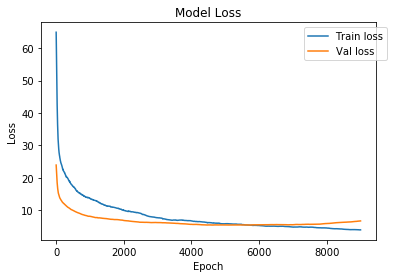

In [31]:
#Plot Model Loss

w = 1000
h1 = np.array(history.history['loss'])
h4 = np.array(history.history['val_loss'])
h1 = moving_average(h1,w)
h4 = moving_average(h4,w)
plt.plot(h1,label='Train loss')
plt.plot(h4,label='Val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

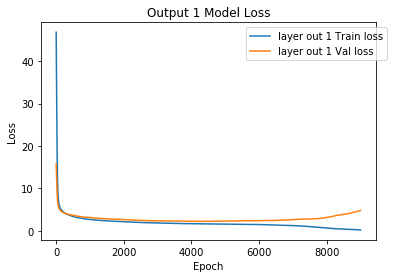

In [32]:
#Plot output 1 loss

h2 = np.array(history.history['out1_loss'])
h5 = np.array(history.history['val_out1_loss'])
h2 = moving_average(h2,w)
h5 = moving_average(h5,w)
plt.plot(h2,label='layer out 1 Train loss')
plt.plot(h5,label='layer out 1 Val loss')
plt.title('Output 1 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

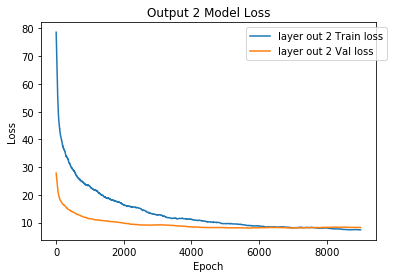

In [33]:
#Plot output 2 loss

h3 = np.array(history.history['out2_loss'])
h6 = np.array(history.history['val_out2_loss'])
h3 = moving_average(h3,w)
h6 = moving_average(h6,w)
plt.plot(h3,label='layer out 2 Train loss')
plt.plot(h6,label='layer out 2 Val loss')
plt.title('Output 2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

In [30]:
#Load ground truth RUL

thr = mat['thr']
fleet_NUM = np.arange(0,pad,1)

rul = pd.read_csv(rul_file,index_col=False)
rul = (rul-1)/(thr-1)
rul_Fleet_All = np.zeros(100)
for x in range(100):
    rul_Fleet_All[x] = rul['RUL'][x]
rul_Fleet_All_Full = ((thr-1)*rul_Fleet_All) + 1
rul_Fleet_All_Full

array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 28., 50., 16., 50., 50., 50., 20., 50., 50.,
       50., 50., 50., 50.,  8., 48., 50.,  7., 11., 19., 21., 50., 50.,
       28., 18., 10., 50., 50., 50., 47., 50., 50., 21., 50., 50., 29.,
       26., 50., 50., 15., 50., 37., 50., 50., 21., 50., 50., 28., 50.,
       14., 50.,  8., 50., 50., 50., 50., 50., 50., 50., 10., 34., 50.,
       50., 50.,  8.,  9., 50., 50., 50., 50., 50., 50., 50., 28., 38.,
       20., 50., 50., 50., 50., 50., 50., 50., 20.])

In [50]:
#Make 100 predictions and calculate average performance

import sklearn
import math
from sklearn import metrics

rmse = np.zeros(100)
rmse1 = np.zeros(100)
sc = np.zeros(100)
sc1 = np.zeros(100)

for i in range(100):
    
    preds = model(x_test)
    tens_draw = preds[0].sample(1000)
    tens_draw1 = preds[1].sample(1000)
    tens_draw2 = preds[2]
    tens_draw = tf.keras.backend.get_value(tens_draw)
    tens_draw1 = tf.keras.backend.get_value(tens_draw1)
    tens_draw2 = tf.keras.backend.get_value(tens_draw2)

    #RMSE with AU

    mean_Fleet_All = np.zeros(tens_draw.shape[1])
    mean_Fleet = np.zeros(tens_draw.shape[0])
    for y in range(tens_draw.shape[1]):
        for x in range(tens_draw.shape[0]):
            mean_Fleet[x] = tens_draw[x,y,0]
        mean_Fleet_All[y] = mean_Fleet.mean()

    RUL_mse = sklearn.metrics.mean_squared_error(rul_Fleet_All_Full, mean_Fleet_All)
    RUL_rmse = math.sqrt(RUL_mse)
    rmse[i] = RUL_rmse

    #RMSE with EU

    mean_Fleet_All1 = np.zeros(tens_draw1.shape[1])
    mean_Fleet1 = np.zeros(tens_draw1.shape[0])
    for y in range(tens_draw1.shape[1]):
        for x in range(tens_draw1.shape[0]):
            mean_Fleet1[x] = tens_draw1[x,y,0]
        mean_Fleet_All1[y] = mean_Fleet1.mean()

    RUL_mse1 = sklearn.metrics.mean_squared_error(rul_Fleet_All_Full, mean_Fleet_All1)
    RUL_rmse1 = math.sqrt(RUL_mse1)
    rmse1[i] = RUL_rmse1
    
    score = mean_Fleet_All-rul_Fleet_All_Full

    for j in range(100):
        if score[j]<0:
            score[j]= math.exp((-score[j])/13)-1
        else:
            score[j] = math.exp(score[j]/10)-1
    
    sc[i] = np.sum(score)
    
    score1 = mean_Fleet_All1-rul_Fleet_All_Full

    for j in range(100):
        if score1[j]<0:
            score1[j]= math.exp((-score1[j])/13)-1
        else:
            score1[j] = math.exp(score1[j]/10)-1
    
    sc1[i] = np.sum(score1)

In [28]:
#Average RMSE with AU & EU
np.mean(rmse),np.mean(rmse1)

(14.681481750280128, 16.041011884279968)

In [29]:
#Average score with AU & EU
np.mean(sc),np.mean(sc1)

(409.0950406373517, 507.63486041665203)

In [51]:
#Calculate Mean & Std of prediction with AU

Fleet = pd.DataFrame(np.zeros((pad,tens_draw.shape[0])))
mean = pd.DataFrame(np.zeros((pad,tens_draw.shape[1])))
std = pd.DataFrame(np.zeros((pad,tens_draw.shape[1])))
for z in range(tens_draw.shape[1]):
    for y in range(tens_draw.shape[0]):
        for x in range(pad):
            Fleet[y][x] = tens_draw[y,z,x]
    row_Mean = Fleet.mean(axis=1)
    row_Std = Fleet.std(axis=1)
    for j in range(pad):
        mean[z][j] = row_Mean[j]
    for k in range(pad):
        std[z][k] = row_Std[k]

In [52]:
#Calculate Mean & Std of prediction with EU

Fleet1 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[0])))
mean1 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[1])))
std1 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[1])))
for z in range(tens_draw1.shape[1]):
    for y in range(tens_draw1.shape[0]):
        for x in range(pad):
            Fleet1[y][x] = tens_draw1[y,z,x]
    row_Mean = Fleet1.mean(axis=1)
    row_Std = Fleet1.std(axis=1)
    for j in range(pad):
        mean1[z][j] = row_Mean[j]
    for k in range(pad):
        std1[z][k] = row_Std[k]

In [34]:
# Saves mean & std AU & EU

#with open('Array_13.npy', 'wb') as f:
    #np.save(f, tens_draw)
    #np.save(f, tens_draw1)
    #np.save(f, tens_draw2)
    #np.save(f, mean)
    #np.save(f, std)
    #np.save(f, mean1)
    #np.save(f, std1)
    
with open('Array_13.npy', 'rb') as f:
    tens_draw = np.load(f)
    tens_draw1 = np.load(f)
    tens_draw2 = np.load(f)
    mean = np.load(f)
    std = np.load(f)
    mean1 = np.load(f)
    std1 = np.load(f)

In [35]:
#Load ground truth RUL

fleet_RUL = pd.read_csv(fleet_Rul_File, skiprows = 0,header = None)

ValueError: x and y must have same first dimension, but have shapes (303,) and (100,)

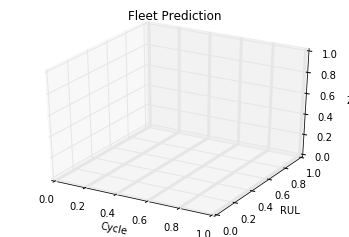

In [42]:
#3d visualization of prediction
from mpl_toolkits import mplot3d
import seaborn as sns
from scipy import stats
from scipy.stats import norm
plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 17

ax.set_title("Fleet Prediction")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.2,label='Predictions')
ax.plot3D(x,y,stats.norm.pdf(y, mu, sigma),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('3D_1.jpg',bbox_inches='tight')
plt.show()

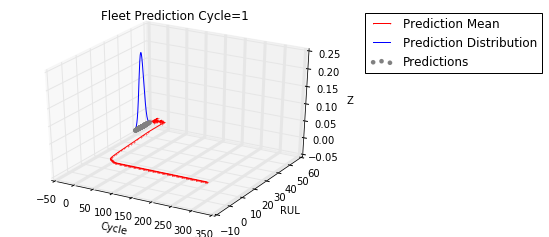

In [53]:
#3d visualization of prediction
from mpl_toolkits import mplot3d
import seaborn as sns
from scipy import stats
from scipy.stats import norm
plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 0

ax.set_title("Fleet Prediction Cycle=1")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.1,label='Predictions')
ax.plot3D(x,y,stats.norm.pdf(y, mu, sigma),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('3D_1.jpg',bbox_inches='tight')
plt.show()

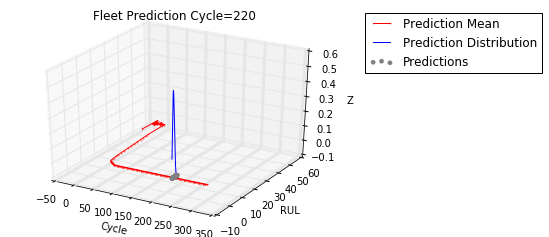

In [55]:
#3d visualization of prediction
from mpl_toolkits import mplot3d
import seaborn as sns
from scipy import stats
from scipy.stats import norm
plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 219

ax.set_title("Fleet Prediction Cycle=220")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.2,label='Predictions')
ax.plot3D(x,y,stats.norm.pdf(y,mean[0][i],std[0][i]),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('3D_2.jpg',bbox_inches='tight')
plt.show()

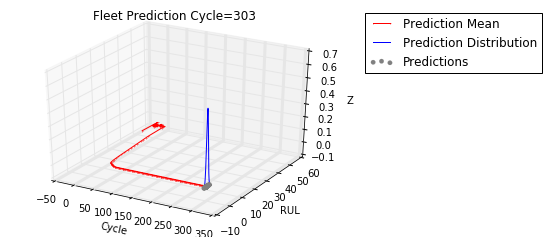

In [56]:
#3d visualization of prediction
from mpl_toolkits import mplot3d
import seaborn as sns
from scipy import stats
from scipy.stats import norm
plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 302

ax.set_title("Fleet Prediction Cycle=303")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.2,label='Predictions')
ax.plot3D(x,y,stats.norm.pdf(y,mean[0][i],std[0][i]),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('3D_3.jpg',bbox_inches='tight')
plt.show()

In [59]:
cycle_lim = np.zeros(100)
S = 0
for K in range(100):
    for L in range(pad):
        if fleet_RUL[K][L] == 0:
            S = 0
            break
        else:
            S = S + 1
            cycle_lim[K] = S

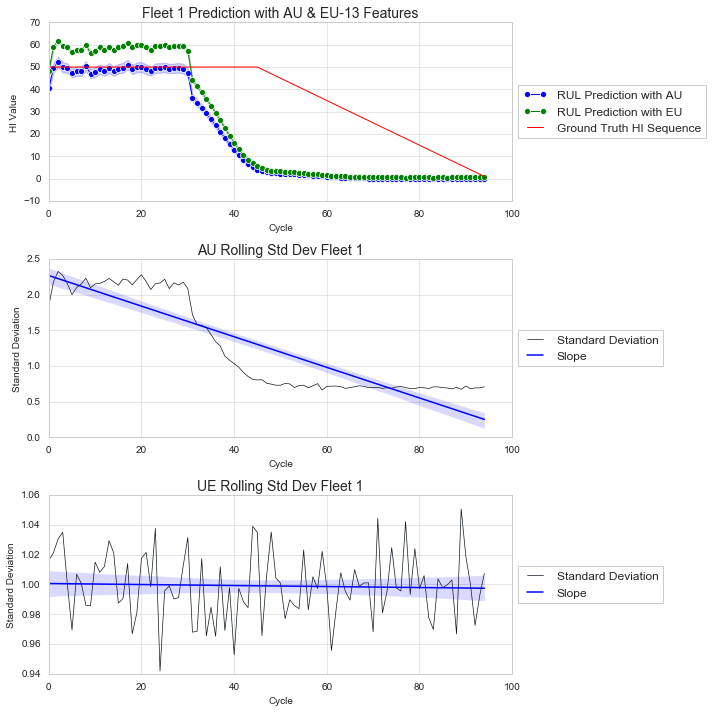

In [60]:
#Visualization Fleet 1

import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy import stats
sns.set_style("whitegrid")
for B in range(0,1):
    lim = int(cycle_lim[B]+1)
    lim2 = int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','HI Value']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','HI Value']
    
    max_Seq_Arrange1.columns = ['Cycle','HI Value']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std[B][x]
    min_Std_Arrange.columns = ['Cycle','HI Value']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std1[B][x]
    med_Std_Arrange.columns = ['Cycle','HI Value']
    
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange, ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange1, ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="HI Value", data = max_RUL_Arrange, color='red', ax=ax,label="Ground Truth HI Sequence")
    plt.title('Fleet %i Prediction with AU & EU-13 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('AU Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('UE Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("Fleet %i Pred" %B+'.jpg')
    plt.tight_layout()
    plt.show()

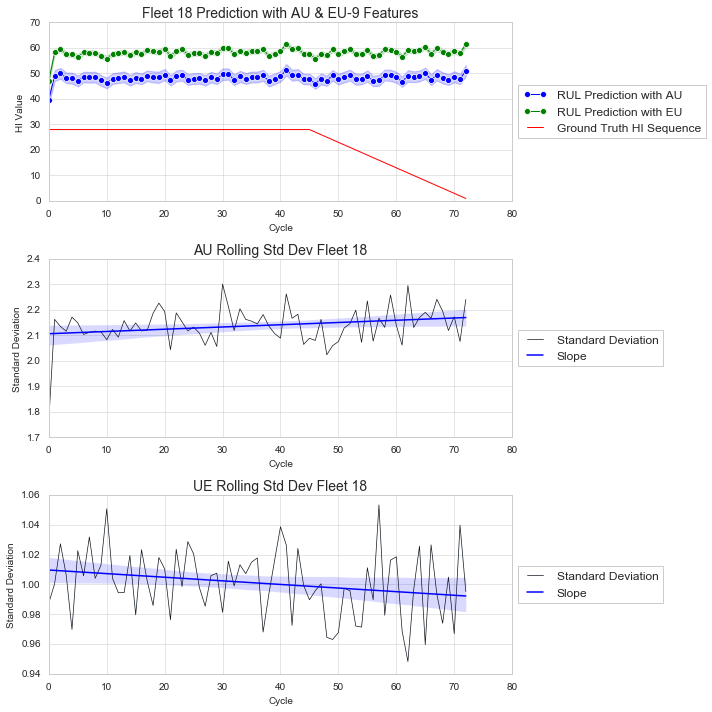

In [61]:
#Visualization Fleet 18

import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy import stats
sns.set_style("whitegrid")
for B in range(17,18):
    lim = int(cycle_lim[B]+1)
    lim2 = int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','HI Value']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','HI Value']
    
    max_Seq_Arrange1.columns = ['Cycle','HI Value']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std[B][x]
    min_Std_Arrange.columns = ['Cycle','HI Value']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std1[B][x]
    med_Std_Arrange.columns = ['Cycle','HI Value']
    
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange, ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange1, ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="HI Value", data = max_RUL_Arrange, color='red', ax=ax,label="Ground Truth HI Sequence")
    plt.title('Fleet %i Prediction with AU & EU-9 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('AU Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('UE Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("Fleet %i Pred" %B+'.jpg')
    plt.tight_layout()
    plt.show()

In [62]:
#Explanation
inputs = tf.keras.Input(shape=(303,13),dtype='float32')
layer1 = LSTM(unit1,return_sequences = True)(inputs)
layer2 = Dense(size1)(layer1)
layer3 = Dense(1)(layer2)
layer4 = Lambda(lambda t: t[:,-1],name='out2')(layer3)
model2 = tf.keras.Model(inputs=inputs, outputs=layer4)
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 303, 13)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 303, 14)           1568      
_________________________________________________________________
dense_3 (Dense)              (None, 303, 178)          2670      
_________________________________________________________________
dense_4 (Dense)              (None, 303, 1)            179       
_________________________________________________________________
out2 (Lambda)                (None, 1)                 0         
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [63]:
model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[1].set_weights(model.layers[1].get_weights())
model2.layers[2].set_weights(model.layers[2].get_weights())
model2.layers[3].set_weights(model.layers[5].get_weights())
model2.layers[4].set_weights(model.layers[8].get_weights())

In [64]:
preds2 = model2(x_test)
y3 = preds2
y3 = tf.keras.backend.get_value(y3)
tens_draw3 = y3

In [65]:
import shap
shap.initjs()

In [66]:
features = pd.read_csv(train_file, index_col=False)
features = features.drop(['Fleet','Cycle','RUL'],axis=1)
features = np.array(list(features.columns))
features

array(['OC1', 'OC3', 'S2', 'S3', 'S4', 'S8', 'S11', 'S12', 'S13', 'S14',
       'S15', 'S20', 'S21'], dtype='<U3')

In [67]:
xtrain = pd.read_csv(train_file, index_col=False)
xtrain = xtrain.drop(['Fleet','Cycle','RUL'],axis=1)

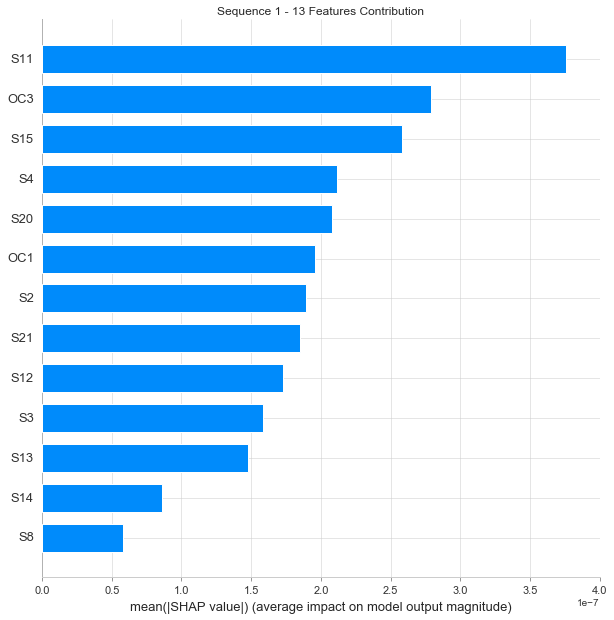

In [69]:
#SHAP Summmary Plot
instance = x_train
instance2 = x_test
explainer = shap.DeepExplainer(model2,instance)
shap_values = explainer.shap_values(instance2)
for i in range(0,1):
    shap.summary_plot(shap_values[0][i],feature_names=xtrain.columns,show=False,plot_size=(10, 10),plot_type="bar")
    plt.title("Sequence %i - 13 Features Contribution" %(i+1),fontsize=12)
    #plt.savefig("Sum_Plot %i" %i+'.png')
    #plt.figure

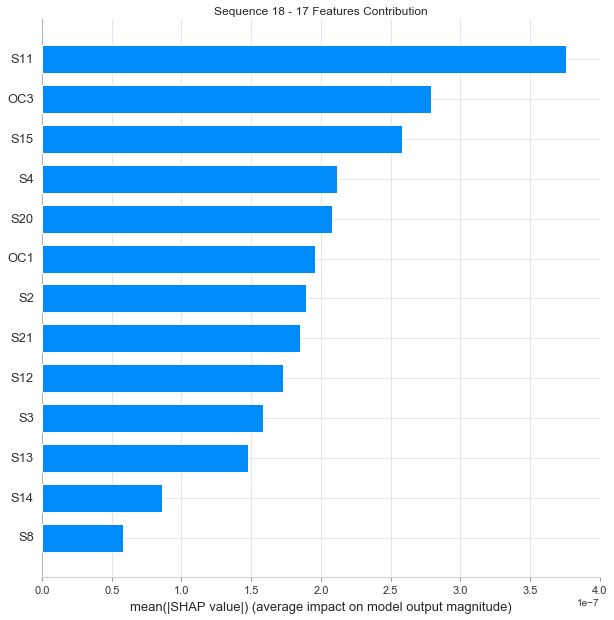

In [70]:
#SHAP Summmary Plot
for i in range(17,18):
    shap.summary_plot(shap_values[0][i],feature_names=xtrain.columns,show=False,plot_size=(10, 10),plot_type="bar")
    plt.title("Sequence %i - 17 Features Contribution" %(i+1),fontsize=12)

In [71]:
#SHAP Force Plot - Matplotlib
sns.set_style("ticks")
for s in range(0,1):
    instance=x_test[s:s+1]
    shap_values = explainer.shap_values(instance)
    e = explainer.expected_value
    # Per individual array 
    for j in range(303):
        print(s+1,j+1)
        xtest_df = pd.DataFrame(data = x_test[s][j].reshape(1,13),columns=features).round(3)
        shap_display = shap.force_plot(e[0],shap_values[0][0][j],xtest_df,matplotlib = False,show = False,figsize=(10, 2),text_rotation=15)
        display(shap_display)

1 1


1 2


1 3


1 4


1 5


1 6


1 7


1 8


1 9


1 10


1 11


1 12


1 13


1 14


1 15


1 16


1 17


1 18


1 19


1 20


1 21


1 22


1 23


1 24


1 25


1 26


1 27


1 28


1 29


1 30


1 31


1 32


1 33


1 34


1 35


1 36


1 37


1 38


1 39


1 40


1 41


1 42


1 43


1 44


1 45


1 46


1 47


1 48


1 49


1 50


1 51


1 52


1 53


1 54


1 55


1 56


1 57


1 58


1 59


1 60


1 61


1 62


1 63


1 64


1 65


1 66


1 67


1 68


1 69


1 70


1 71


1 72


1 73


1 74


1 75


1 76


1 77


1 78


1 79


1 80


1 81


1 82


1 83


1 84


1 85


1 86


1 87


1 88


1 89


1 90


1 91


1 92


1 93


1 94


1 95


1 96


1 97


1 98


1 99


1 100


1 101


1 102


1 103


1 104


1 105


1 106


1 107


1 108


1 109


1 110


1 111


1 112


1 113


1 114


1 115


1 116


1 117


1 118


1 119


1 120


1 121


1 122


1 123


1 124


1 125


1 126


1 127


1 128


1 129


1 130


1 131


1 132


1 133


1 134


1 135


1 136


1 137


1 138


1 139


1 140


1 141


1 142


1 143


1 144


1 145


1 146


1 147


1 148


1 149


1 150


1 151


1 152


1 153


1 154


1 155


1 156


1 157


1 158


1 159


1 160


1 161


1 162


1 163


1 164


1 165


1 166


1 167


1 168


1 169


1 170


1 171


1 172


1 173


1 174


1 175


1 176


1 177


1 178


1 179


1 180


1 181


1 182


1 183


1 184


1 185


1 186


1 187


1 188


1 189


1 190


1 191


1 192


1 193


1 194


1 195


1 196


1 197


1 198


1 199


1 200


1 201


1 202


1 203


1 204


1 205


1 206


1 207


1 208


1 209


1 210


1 211


1 212


1 213


1 214


1 215


1 216


1 217


1 218


1 219


1 220


1 221


1 222


1 223


1 224


1 225


1 226


1 227


1 228


1 229


1 230


1 231


1 232


1 233


1 234


1 235


1 236


1 237


1 238


1 239


1 240


1 241


1 242


1 243


1 244


1 245


1 246


1 247


1 248


1 249


1 250


1 251


1 252


1 253


1 254


1 255


1 256


1 257


1 258


1 259


1 260


1 261


1 262


1 263


1 264


1 265


1 266


1 267


1 268


1 269


1 270


1 271


1 272


1 273


1 274


1 275


1 276


1 277


1 278


1 279


1 280


1 281


1 282


1 283


1 284


1 285


1 286


1 287


1 288


1 289


1 290


1 291


1 292


1 293


1 294


1 295


1 296


1 297


1 298


1 299


1 300


1 301


1 302


1 303


In [72]:
for s in range(17,18):
    instance=x_test[s:s+1]
    shap_values = explainer.shap_values(instance)
    e = explainer.expected_value
    # Per individual array 
    for j in range(303):
        print(s+1,j+1)
        xtest_df = pd.DataFrame(data = x_test[s][j].reshape(1,13),columns=features).round(3)
        shap_display = shap.force_plot(e[0],shap_values[0][0][j],xtest_df,matplotlib = False,show = False,figsize=(10, 2),text_rotation=15)
        display(shap_display)

18 1


18 2


18 3


18 4


18 5


18 6


18 7


18 8


18 9


18 10


18 11


18 12


18 13


18 14


18 15


18 16


18 17


18 18


18 19


18 20


18 21


18 22


18 23


18 24


18 25


18 26


18 27


18 28


18 29


18 30


18 31


18 32


18 33


18 34


18 35


18 36


18 37


18 38


18 39


18 40


18 41


18 42


18 43


18 44


18 45


18 46


18 47


18 48


18 49


18 50


18 51


18 52


18 53


18 54


18 55


18 56


18 57


18 58


18 59


18 60


18 61


18 62


18 63


18 64


18 65


18 66


18 67


18 68


18 69


18 70


18 71


18 72


18 73


18 74


18 75


18 76


18 77


18 78


18 79


18 80


18 81


18 82


18 83


18 84


18 85


18 86


18 87


18 88


18 89


18 90


18 91


18 92


18 93


18 94


18 95


18 96


18 97


18 98


18 99


18 100


18 101


18 102


18 103


18 104


18 105


18 106


18 107


18 108


18 109


18 110


18 111


18 112


18 113


18 114


18 115


18 116


18 117


18 118


18 119


18 120


18 121


18 122


18 123


18 124


18 125


18 126


18 127


18 128


18 129


18 130


18 131


18 132


18 133


18 134


18 135


18 136


18 137


18 138


18 139


18 140


18 141


18 142


18 143


18 144


18 145


18 146


18 147


18 148


18 149


18 150


18 151


18 152


18 153


18 154


18 155


18 156


18 157


18 158


18 159


18 160


18 161


18 162


18 163


18 164


18 165


18 166


18 167


18 168


18 169


18 170


18 171


18 172


18 173


18 174


18 175


18 176


18 177


18 178


18 179


18 180


18 181


18 182


18 183


18 184


18 185


18 186


18 187


18 188


18 189


18 190


18 191


18 192


18 193


18 194


18 195


18 196


18 197


18 198


18 199


18 200


18 201


18 202


18 203


18 204


18 205


18 206


18 207


18 208


18 209


18 210


18 211


18 212


18 213


18 214


18 215


18 216


18 217


18 218


18 219


18 220


18 221


18 222


18 223


18 224


18 225


18 226


18 227


18 228


18 229


18 230


18 231


18 232


18 233


18 234


18 235


18 236


18 237


18 238


18 239


18 240


18 241


18 242


18 243


18 244


18 245


18 246


18 247


18 248


18 249


18 250


18 251


18 252


18 253


18 254


18 255


18 256


18 257


18 258


18 259


18 260


18 261


18 262


18 263


18 264


18 265


18 266


18 267


18 268


18 269


18 270


18 271


18 272


18 273


18 274


18 275


18 276


18 277


18 278


18 279


18 280


18 281


18 282


18 283


18 284


18 285


18 286


18 287


18 288


18 289


18 290


18 291


18 292


18 293


18 294


18 295


18 296


18 297


18 298


18 299


18 300


18 301


18 302


18 303
